In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as model
from sklearn.linear_model import LinearRegression as ols_model
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from scipy import stats
from datetime import date
import os.path
import pickle

# A module allowing for improved workflow with
# datasets sourced from the Gene Expression Omnibus.
import geo_tools as gt

C:\Users\blanc\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def process_data(GSE_list, info= "age"):
    
    """Takes in a list of GSEs, returns a corresponding X_df and y."""
    
    # making X
    GSE_df_dict = {}
    GSE_df_list = []

    for GSE in GSE_list:

        GSE_df = gt.series(GSE).transpose()

        # IDing with both GSE and GSM codes.
        multi_index_arrays = [[], []]
        for GSM in GSE_df.index:
            multi_index_arrays[0].append(GSE)
            multi_index_arrays[1].append(GSM)

        GSE_df.index =  pd.MultiIndex.from_arrays(multi_index_arrays)

        # Many datsets come with missing values.
        GSE_df.fillna(inplace= True, method= 'ffill')
        GSE_df.fillna(inplace= True, method= 'bfill')

        GSE_df_dict[GSE] = GSE_df
        GSE_df_list.append(GSE_df)

    X_df = pd.concat(GSE_df_list)

    # Let's manually remove the rows that still contain NaNs that
    # the pandas library wasn't able to deal with.
    samples_na = X_df.isna().any(axis= 1)

    for sample in samples_na.index:
        if samples_na.loc[sample]:
            X_df.drop(labels= sample, inplace= True)

    y = []
    for row in X_df.index:
        y.append(gt.info(row[0], row[1], info= info))
        
    index_arr = [re.match("cg", label) == None for label in X_df.columns]
    bad_labels = np.array(X_df.columns)[index_arr]
    
    X_df.drop(labels= bad_labels, axis= "columns", inplace= True)
            
    return X_df, y

In [3]:
temp_data_28k = ["GSE41037"]

In [4]:
temp_data_450k = ["GSE40279"]

In [5]:
temp_data_850k = ["GSE100825"]

In [6]:
temp_28k_X, _ = process_data(temp_data_28k)
temp_450k_X, _ = process_data(temp_data_450k)
temp_850k_X, _ = process_data(temp_data_850k)

In [7]:
CpG_set_28k = set(temp_28k_X.columns)
CpG_set_450k = set(temp_450k_X.columns)
CpG_set_850k = set(temp_850k_X.columns)

small_CpG_list = list(CpG_set_28k.intersection(CpG_set_450k).intersection(CpG_set_850k))
medium_CpG_list = list(CpG_set_450k.intersection(CpG_set_850k))
large_CpG_list = list(CpG_set_850k)

In [8]:
del temp_data_28k, temp_data_450k, temp_data_850k

In [9]:
del temp_28k_X, temp_450k_X, temp_850k_X

## The Small Model

In [10]:
small_data = ["GSE41037", "GSE20067", "GSE20236", "GSE19711"]

In [11]:
small_X, small_age = process_data(small_data)

In [12]:
small_X = small_X[small_CpG_list]

In [13]:
small_scaler = StandardScaler()

In [14]:
small_X_train, small_X_test, small_age_train, small_age_test = train_test_split(small_X, small_age, test_size= 0.20)

In [15]:
small_X_train = small_scaler.fit_transform(small_X_train)
small_X_test = small_scaler.transform(small_X_test)

In [16]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# small_model = model.ElasticNetCV(l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], selection= "random")
# small_model.fit(small_X_train, small_age_train)

# alpha= 0.3258451445804574
# l1_ratio= 0.4

small_model = model.ElasticNet(alpha= 0.3258451445804574, l1_ratio= 0.4)
small_model.fit(small_X_train, small_age_train)

C:\Users\blanc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1686.5586885771936, tolerance: 47.09963737113403
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.3258451445804574, l1_ratio=0.4)

In [17]:
small_X_test_predict = small_model.predict(small_X_test)

In [18]:
FIGURES_DIR = "./final_clock_figures/"
if not os.path.exists(FIGURES_DIR):
    os.mkdir(FIGURES_DIR)

In [19]:
def finalize_scatter_plot(x, y, model_name, file_name):
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    plt.title(f"DNAm pred. vs actual age\n{model_name}\nr= {r}\nMAE= {mae_val}", loc= "right")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    accuracy_line = [0, 100]
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("actual age", fontsize= 15)
    plt.ylabel("DNAm predicted age", fontsize= 15)
    plt.legend()
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

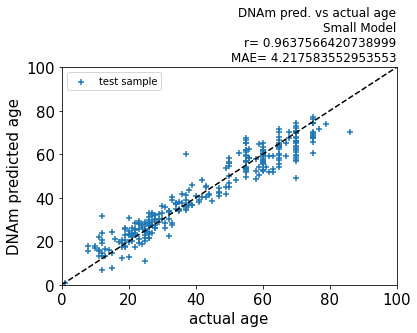

In [20]:
plt.scatter(small_age_test, small_X_test_predict, label= "test sample", marker= "+")
small_file_name = os.path.join(FIGURES_DIR, "small_model_test")
finalize_scatter_plot(small_age_test, small_X_test_predict, "Small Model", small_file_name)

## The Medium Model

In [21]:
medium_data = ["GSE40279"]

In [22]:
medium_X, medium_age = process_data(medium_data)

In [23]:
medium_X = medium_X[medium_CpG_list]

In [24]:
medium_indices_to_cpg_labels = dict()
index = 0
for cpg in medium_X.columns:
    medium_indices_to_cpg_labels[index] = cpg
    index += 1
medium_indices_to_cpg_labels

{0: 'cg26762050',
 1: 'cg21705600',
 2: 'cg19474418',
 3: 'cg00124009',
 4: 'cg14449317',
 5: 'cg27351896',
 6: 'cg25350827',
 7: 'cg25925896',
 8: 'cg27658698',
 9: 'cg20480274',
 10: 'cg22736144',
 11: 'cg24861444',
 12: 'cg08486903',
 13: 'cg22955798',
 14: 'cg26684131',
 15: 'cg20302497',
 16: 'cg05404847',
 17: 'cg11705208',
 18: 'cg12409226',
 19: 'cg18807895',
 20: 'cg15107117',
 21: 'cg24339193',
 22: 'cg07706387',
 23: 'cg07269364',
 24: 'cg24724630',
 25: 'cg27483694',
 26: 'cg12972081',
 27: 'cg03339704',
 28: 'cg16889489',
 29: 'cg25777212',
 30: 'cg02447287',
 31: 'cg17410313',
 32: 'cg12789522',
 33: 'cg17725461',
 34: 'cg00999904',
 35: 'cg09897737',
 36: 'cg12368542',
 37: 'cg24873093',
 38: 'cg27053538',
 39: 'cg15871531',
 40: 'cg15910070',
 41: 'cg00796416',
 42: 'cg18595780',
 43: 'cg01150641',
 44: 'cg05620762',
 45: 'cg08385173',
 46: 'cg13671721',
 47: 'cg11003984',
 48: 'cg00295382',
 49: 'cg09324653',
 50: 'cg10184376',
 51: 'cg05580277',
 52: 'cg13922858',
 53

In [25]:
medium_scaler = StandardScaler()

In [26]:
medium_X_train, medium_X_test, medium_age_train, medium_age_test = train_test_split(medium_X, medium_age, test_size= 0.20)

In [27]:
medium_X_train = medium_scaler.fit_transform(medium_X_train)
medium_X_test = medium_scaler.transform(medium_X_test)

In [28]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# medium_model = model.ElasticNetCV(l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], selection= "random")
# medium_model.fit(medium_X_train, medium_age_train)

# alpha= 0.06470723076032536
# l1_ratio= 0.2

medium_model = model.ElasticNet(alpha= 0.06470723076032536, l1_ratio= 0.2)
medium_model.fit(medium_X_train, medium_age_train)

C:\Users\blanc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.9637947846466, tolerance: 11.621524427480916
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.06470723076032536, l1_ratio=0.2)

In [29]:
medium_X_test_predict = medium_model.predict(medium_X_test)

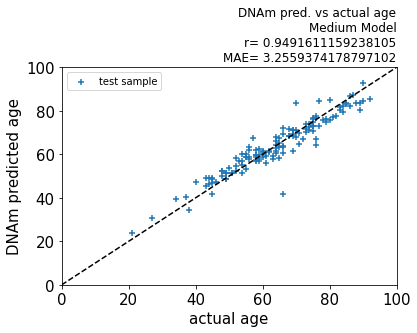

In [30]:
plt.scatter(medium_age_test, medium_X_test_predict, label= "test sample", marker= "+")
medium_file_name = os.path.join(FIGURES_DIR, "medium_model_test")
finalize_scatter_plot(medium_age_test, medium_X_test_predict, "Medium Model", medium_file_name)

In [31]:
def get_non_zero_cpgs_indices(model):
    non_zero_indices = np.array([])
    coef_index = 0
    for coef in model.coef_:
        if coef != 0:
            non_zero_indices = np.append(non_zero_indices, coef_index)
            
        coef_index += 1
        
    return non_zero_indices

In [32]:
medium_model_non_zero_cpg_indices = get_non_zero_cpgs_indices(medium_model)

In [33]:
medium_model_non_zero_cpg_labels = []
for i in medium_model_non_zero_cpg_indices:
    label = medium_indices_to_cpg_labels[i]
    medium_model_non_zero_cpg_labels.append(label)

medium_model_non_zero_cpg_labels, len(medium_model_non_zero_cpg_labels)

(['cg13895393',
  'cg22134372',
  'cg01763090',
  'cg17034331',
  'cg11807280',
  'cg23995914',
  'cg25674883',
  'cg02460371',
  'cg18881873',
  'cg03614916',
  'cg04677833',
  'cg07996594',
  'cg23669043',
  'cg14413354',
  'cg14016177',
  'cg11571588',
  'cg24611446',
  'cg01773059',
  'cg17465920',
  'cg14645415',
  'cg02767539',
  'cg07850154',
  'cg21038382',
  'cg17885226',
  'cg09815962',
  'cg02241397',
  'cg01962405',
  'cg10628205',
  'cg00120464',
  'cg19263761',
  'cg21449170',
  'cg15426878',
  'cg26280666',
  'cg13893459',
  'cg20648272',
  'cg04027548',
  'cg02299136',
  'cg25021575',
  'cg26889552',
  'cg03301331',
  'cg21868031',
  'cg21333674',
  'cg24056028',
  'cg21159568',
  'cg27648006',
  'cg27320127',
  'cg03032497',
  'cg02475675',
  'cg09714424',
  'cg07898264',
  'cg26857078',
  'cg22140756',
  'cg04347158',
  'cg11830800',
  'cg24554061',
  'cg17750334',
  'cg17898329',
  'cg02910553',
  'cg26725502',
  'cg20149168',
  'cg07610822',
  'cg18445088',
  'cg174

In [34]:
d = {"label": medium_model_non_zero_cpg_labels}
medium_model_non_zero_cpg_labels_df = pd.DataFrame(data=d)
medium_model_non_zero_cpg_labels_df.head(5)

,label
0,cg13895393
1,cg22134372
2,cg01763090
3,cg17034331
4,cg11807280


In [35]:
medium_model_non_zero_cpg_labels_df.to_csv("1st_gen_medium_model_cpg_labels.csv")

In [36]:
len(medium_model.coef_), len(medium_CpG_list)

(438866, 438866)

### Medium Model test on Werner Syndrome dataset

In [37]:
werner_file = open("./Werner_Syndrome.pickle", mode= "rb")

In [38]:
werner_df = pickle.load(werner_file)
werner_df

ID_REF                cg00000029  cg00000103  cg00000109  cg00000155  \
GSE100825 GSM2694066    0.646562    0.878838    0.905579    0.925186   
          GSM2694067    0.538249    0.902410    0.904032    0.934665   
          GSM2694068    0.527190    0.898359    0.885479    0.925673   
          GSM2694069    0.516348    0.884633    0.882224    0.920914   
          GSM2694070    0.421783    0.877394    0.884108    0.903828   
          GSM2694071    0.563347    0.877676    0.902442    0.930035   

ID_REF                cg00000158  cg00000165  cg00000221  cg00000236  \
GSE100825 GSM2694066    0.932245    0.106970    0.861418    0.761809   
          GSM2694067    0.935280    0.113383    0.886281    0.785804   
          GSM2694068    0.941409    0.150861    0.866107    0.832197   
          GSM2694069    0.937409    0.059281    0.887977    0.712423   
          GSM2694070    0.932568    0.095332    0.872783    0.737723   
          GSM2694071    0.912951    0.124959    0.901731    0.752412   

ID_REF                cg00000289  cg00000292  ...  cg27665913  cg27665925  \
GSE100825 GSM2694066    0.778761    0.811275  ...    0.900759    0.011261   
          GSM2694067    0.777328    0.815536  ...    0.918351    0.012891   
          GSM2694068    0.737792    0.836610  ...    0.910301    0.012986   
          GSM2694069    0.834136    0.788549  ...    0.897614    0.012966   
          GSM2694070    0.791135    0.841383  ...    0.921618    0.012990   
          GSM2694071    0.797080    0.806697  ...    0.920886    0.012712   

ID_REF                cg27665978  cg27665985  cg27666046  cg27666049  \
GSE100825 GSM2694066    0.844620    0.244657    0.564599    0.868386   
          GSM2694067    0.859105    0.341572    0.555774    0.816575   
          GSM2694068    0.834268    0.404887    0.388906    0.841959   
          GSM2694069    0.876654    0.250914    0.710208    0.844317   
          GSM2694070    0.862241    0.274147    0.572511    0.891965   
          GSM2694071    0.860147    0.265730    0.579267    0.890517   

ID_REF                cg27666060  cg27666108  cg27666123   age  
GSE100825 GSM2694066    0.824801    0.233204    0.839785  51.0  
          GSM2694067    0.831095    0.270234    0.863915  44.0  
          GSM2694068    0.825738    0.293093    0.796659  53.0  
          GSM2694069    0.873103    0.244478    0.852989  53.0  
          GSM2694070    0.828678    0.248083    0.849475  44.0  
          GSM2694071    0.847140    0.312648    0.882008  52.0  

[6 rows x 863905 columns]

In [39]:
werner_ages = np.array(werner_df["age"])

In [40]:
werner_df = werner_df[medium_CpG_list]

In [41]:
werner_df = werner_df.fillna(method= "pad")

In [42]:
werner_df = medium_scaler.transform(werner_df)
werner_df

array([[ 8.81223635e-02,  7.05276293e-02, -1.15262331e+00, ...,
        -4.08077551e-02, -1.38785383e+00, -2.13479953e-01],
       [ 8.48537233e-01, -1.89079381e+00, -1.27405874e+00, ...,
        -3.25399943e-01, -1.28954914e+00,  6.09383605e-01],
       [ 1.76306194e+00,  3.99198701e-01, -1.28495187e+00, ...,
        -1.56631232e-01, -1.27832815e+00, -2.25305303e-03],
       [ 8.38214800e-01, -2.53793586e-01, -9.27972554e-01, ...,
        -3.66912605e-01, -1.29822632e+00, -3.66792805e+00],
       [ 6.82645881e-01,  7.98091803e-01, -1.01714427e+00, ...,
         9.88640103e-02, -1.37847086e+00,  7.00569834e-02],
       [-1.41663964e-01, -1.28942883e-01, -1.05922368e+00, ...,
        -7.58884692e-02, -1.31879939e+00, -5.94188599e-01]])

In [43]:
werner_age_pred = medium_model.predict(werner_df)

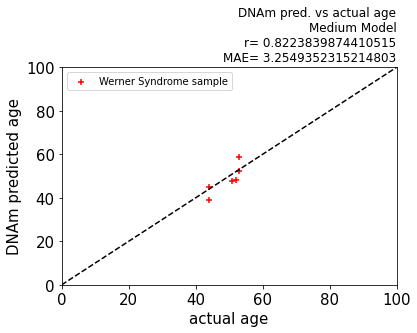

In [44]:
plt.scatter(werner_ages, werner_age_pred, label= "Werner Syndrome sample", marker= "+", color= "red")
werner_filename = os.path.join(FIGURES_DIR, "medium_model_werner_syndrome_test")
finalize_scatter_plot(werner_ages, werner_age_pred, "Medium Model", werner_filename)

In [45]:
d = {"pred_age": werner_age_pred, "actual_age": werner_ages}
d

{'pred_age': array([47.63645874, 39.05763878, 52.23116261, 58.6078532 , 44.95046006,
        48.10344173]),
 'actual_age': array([51., 44., 53., 53., 44., 52.])}

In [46]:
werner_results = pd.DataFrame(data= d)
werner_results

,pred_age,actual_age
0,47.636459,51.0
1,39.057639,44.0
2,52.231163,53.0
3,58.607853,53.0
4,44.950460,44.0
5,48.103442,52.0


In [47]:
werner_results.to_csv("./werner_syndrome_results.csv")

### Medium Model test on IBS set

In [48]:
ibs_file = open("./IBS.pkl", mode= "rb")

In [49]:
ibs_df = pickle.load(ibs_file)
ibs_df

ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873
GSM2336818,0.484840,0.904301,0.706628,0.268115,0.696812,0.552807,0.731842,0.355477,0.351903,0.045642,...,0.553988,0.477160,0.555363,0.532696,0.508120,0.259912,0.557469,0.902920,0.806501,0.722293
GSM2336819,0.549209,0.899991,0.757192,0.254714,0.782396,0.537098,0.826841,0.343745,0.383886,0.043136,...,0.542820,0.944774,0.485624,0.942371,0.488452,0.855391,0.581672,0.922380,0.817588,0.797783
GSM2336820,0.665182,0.910282,0.814520,0.241178,0.776249,0.676952,0.871598,0.327974,0.418875,0.040509,...,0.672129,0.056950,0.693259,0.540354,0.637202,0.640432,0.578289,0.566337,0.387525,0.860193
GSM2336821,0.536237,0.898268,0.796119,0.244020,0.723803,0.561323,0.829576,0.283472,0.408616,0.046047,...,0.932671,0.065737,0.522881,0.536366,0.920109,0.113204,0.602383,0.079792,0.571661,0.848829
GSM2336822,0.450374,0.906696,0.776311,0.250357,0.726807,0.578344,0.777413,0.261513,0.396494,0.044639,...,0.541303,0.059852,0.524525,0.940133,0.469027,0.596338,0.561113,0.522132,0.610090,0.641714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2337053,0.754166,0.924941,0.826363,0.278728,0.859885,0.658426,0.895978,0.461872,0.472104,0.043561,...,0.535310,0.061385,0.470220,0.608104,0.535429,0.111257,0.916240,0.492598,0.159320,0.703948
GSM2337054,0.544069,0.922609,0.834624,0.280992,0.713173,0.659256,0.802371,0.300417,0.427558,0.051920,...,0.529538,0.460318,0.136502,0.945212,0.530844,0.899833,0.105268,0.516616,0.168397,0.856872
GSM2337055,0.574472,0.930687,0.836744,0.268772,0.769004,0.707079,0.853384,0.290878,0.466079,0.057271,...,0.070562,0.947828,0.114142,0.063007,0.060613,0.580962,0.604596,0.070221,0.543221,0.678708
GSM2337056,0.538766,0.937964,0.865123,0.271731,0.762731,0.784256,0.871394,0.294934,0.391865,0.053007,...,0.076908,0.463673,0.476765,0.947183,0.926799,0.094965,0.570425,0.075604,0.899900,0.897679


In [50]:
ibs_ages = pd.read_csv("./IBS ages.csv")
ibs_ages

,Unnamed: 0,Disease State,Gender,Age
0,GSM2336818,CD,F,19.1
1,GSM2336819,HC,M,30.8
2,GSM2336820,UC,M,58.4
3,GSM2336821,CD,M,21.1
4,GSM2336822,CD,F,40.3
...,...,...,...,...
235,GSM2337053,CD,M,30.3
236,GSM2337054,UC,F,26.5
237,GSM2337055,HC,M,27.3
238,GSM2337056,UC,F,19.1


In [51]:
age_vals = ibs_ages["Age"]

In [52]:
disease_state = ibs_ages["Disease State"]

In [53]:
cd_indices = []
hc_indices = []
uc_indices = []

In [54]:
for state in disease_state:
    if state == "CD":
        cd_indices.append(True)
        hc_indices.append(False)
        uc_indices.append(False)
        continue
        
    if state == "HC":
        cd_indices.append(False)
        hc_indices.append(True)
        uc_indices.append(False)
        continue
        
    if state == "UC":
        cd_indices.append(False)
        hc_indices.append(False)
        uc_indices.append(True)
        continue

In [55]:
ibs_df = ibs_df.fillna(method= "pad")

In [56]:
ibs_df = ibs_df[medium_CpG_list]

In [57]:
ibs_df = medium_scaler.transform(ibs_df)
ibs_df

array([[ 0.44452959,  0.19049871,  2.71696445, ..., -4.70829686,
         5.4323631 ,  0.89281229],
       [-0.70909035, -1.04308427,  3.82855429, ..., -2.96972139,
         4.21732426,  1.03548054],
       [ 1.0549652 ,  0.87853993,  3.22142955, ..., -3.3080816 ,
         6.00361513,  1.33462432],
       ...,
       [ 0.63393513, -0.76920858,  3.263392  , ..., -3.06349125,
         4.3231865 ,  1.67600095],
       [ 1.78738018,  0.29538745,  3.32602645, ..., -2.90015103,
         3.36916213,  1.04278464],
       [ 0.2223548 , -0.01488735,  3.25007719, ..., -2.35824489,
         4.53479235,  1.50899364]])

In [58]:
ibs_age_pred = medium_model.predict(ibs_df)
ibs_age_pred

array([33.11665172, 32.44688095, 15.68275389, 25.69714697, 49.68357425,
       23.94370313, 21.85708349, 40.38180117, 53.50087289, 37.79020712,
       57.82938415, 36.26164702, 62.29390982, 28.33160482, 45.72397109,
       39.07866028, 68.09323282, 46.92747407, 42.41687578, 21.19972897,
       56.21221744, 40.907768  , 34.83314975, 39.54856859, 13.6162628 ,
       29.68610777, 37.88978557, 35.44772286, 46.91513839, 27.52503311,
        9.0151987 , 17.36082465, 46.72731225, 18.29077062, 44.10647369,
       36.37249318, 38.29507645, 29.41994753, 40.3575446 , 46.55677743,
       55.58657173, 32.04671863, 32.33594637, 44.26728442, 33.34775643,
       24.60195569, 41.31086738, 33.85815009, 48.97958367, 51.33108028,
       48.11513877, 30.85261948, 41.5221996 , 72.59249137, 52.4244608 ,
       26.78081126, 20.55398482, 38.84830679, 58.05752242, 52.68979781,
       42.08653387, 31.70736636, 34.5604971 , 25.98307492, 40.71730067,
       20.18698689, 50.9425892 , 31.18409878, 53.91265455, 41.69

In [59]:
age_vals = np.array(age_vals)
age_vals

array([19.1, 30.8, 58.4, 21.1, 40.3, 23.4, 24.3, 40.3, 63.7, 30.7, 58.5,
       50.7, 62.4, 38. , 42.1, 37.4, 63.7, 52.4, 33.4, 27.6, 50.4, 34.9,
       27.9, 30. , 26.5, 22.6, 37.5, 41.5, 52.1, 33.1, 22.4, 24.3, 37.5,
       30.8, 33.4, 27.6, 31.3, 31.3, 32.6, 54.3, 49.1, 23.4, 58.4, 43.9,
       33.1, 34. , 30.3, 30.8, 50.4, 62.4, 42.8, 37.4, 38. , 63.7, 38.2,
       26.7, 33.7, 32.6, 56.3, 56.3, 30.3, 49.1, 24.3, 22.6, 36.8, 25.2,
       41.5, 26.2, 50.7, 33.1, 52.1, 58.5, 38. , 37.4, 19.7, 37. , 33.7,
       40.2, 31.1, 26.7, 58.4, 43.9, 30.8, 25.1, 24.3, 19.7, 19.1, 33.4,
       50.7, 30.8, 25.2, 56.3, 58.5, 32.6, 25.1, 50.4, 52.4, 52.1, 58.1,
       25.2, 31.3, 20.5, 33.4, 30.3, 43.9, 26.2, 42.7, 22.4, 24.3, 31.1,
       38.2, 31.1, 24.3, 40.3, 30.3, 50.4, 30.8, 37.4, 25.1, 30.8, 23.4,
       34.9, 38.6, 20.5, 33.1, 22.3, 38.6, 42.1, 26.2, 32.6, 58.1, 40.2,
       54.3, 29.8, 30.7, 42.8, 18.3, 40.3, 42.7, 43.9, 18.3, 37. , 19.1,
       30.8, 18.3, 30.7, 30.8, 41.5, 58.1, 54.3, 22

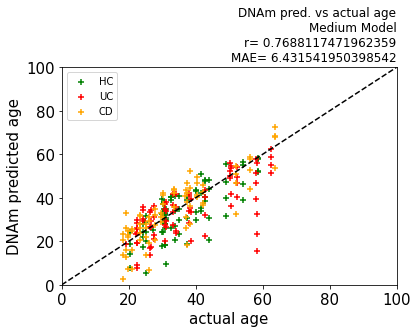

In [60]:
plt.scatter(age_vals[hc_indices], ibs_age_pred[hc_indices], label= "HC", marker= "+", color= "green")
plt.scatter(age_vals[uc_indices], ibs_age_pred[uc_indices], label= "UC", marker= "+", color= "red")
plt.scatter(age_vals[cd_indices], ibs_age_pred[cd_indices], label= "CD", marker= "+", color= "orange")

ibs_file_name = os.path.join(FIGURES_DIR, "ibs_test")
finalize_scatter_plot(age_vals, ibs_age_pred, "Medium Model", ibs_file_name)

In [61]:
d = {"pred_age": ibs_age_pred, "actual_age": age_vals}
d

{'pred_age': array([33.11665172, 32.44688095, 15.68275389, 25.69714697, 49.68357425,
        23.94370313, 21.85708349, 40.38180117, 53.50087289, 37.79020712,
        57.82938415, 36.26164702, 62.29390982, 28.33160482, 45.72397109,
        39.07866028, 68.09323282, 46.92747407, 42.41687578, 21.19972897,
        56.21221744, 40.907768  , 34.83314975, 39.54856859, 13.6162628 ,
        29.68610777, 37.88978557, 35.44772286, 46.91513839, 27.52503311,
         9.0151987 , 17.36082465, 46.72731225, 18.29077062, 44.10647369,
        36.37249318, 38.29507645, 29.41994753, 40.3575446 , 46.55677743,
        55.58657173, 32.04671863, 32.33594637, 44.26728442, 33.34775643,
        24.60195569, 41.31086738, 33.85815009, 48.97958367, 51.33108028,
        48.11513877, 30.85261948, 41.5221996 , 72.59249137, 52.4244608 ,
        26.78081126, 20.55398482, 38.84830679, 58.05752242, 52.68979781,
        42.08653387, 31.70736636, 34.5604971 , 25.98307492, 40.71730067,
        20.18698689, 50.9425892 , 31.18

In [62]:
ibs_results = pd.DataFrame(data= d)
ibs_results

,pred_age,actual_age
0,33.116652,19.1
1,32.446881,30.8
2,15.682754,58.4
3,25.697147,21.1
4,49.683574,40.3
...,...,...
235,31.300838,30.3
236,33.695475,26.5
237,25.343106,27.3
238,18.805526,19.1


In [63]:
ibs_results.to_csv("./ibs_results.csv")

## BRCA1 set

In [64]:
brca1_data = ["GSE57285"]

In [65]:
X_brca1, y_brca1 = process_data(brca1_data)

In [66]:
_, brca_stat = process_data(brca1_data, info= "brca1")

In [67]:
brca_c0_ind = [0 == code for code in brca_stat]
brca_c1_ind = [1 == code for code in brca_stat]
brca_c2_ind = [2 == code for code in brca_stat]

### Testing the Small Model

In [68]:
X_brca1_small = X_brca1[small_CpG_list]

In [69]:
X_brca1_small.head(4)

ID_REF               cg25290938  cg06628693  cg08490173  cg14350002  \
GSE57285 GSM1378474    0.063277    0.097658    0.039312    0.031483   
         GSM1378475    0.063844    0.081633    0.044678    0.030093   
         GSM1378476    0.064471    0.124284    0.050901    0.049267   
         GSM1378477    0.052082    0.091585    0.048095    0.047609   

ID_REF               cg16564824  cg01204439  cg20387341  cg16664233  \
GSE57285 GSM1378474    0.036193    0.051636    0.085475    0.024321   
         GSM1378475    0.034411    0.051216    0.078090    0.027128   
         GSM1378476    0.045604    0.051836    0.064371    0.039086   
         GSM1378477    0.032115    0.052152    0.070420    0.028802   

ID_REF               cg23244421  cg22396755  ...  cg14764661  cg00769520  \
GSE57285 GSM1378474    0.026083    0.064549  ...    0.064083    0.023596   
         GSM1378475    0.027607    0.089394  ...    0.063697    0.034895   
         GSM1378476    0.029187    0.067799  ...    0.046588    0.034197   
         GSM1378477    0.025249    0.064319  ...    0.046696    0.026990   

ID_REF               cg10298205  cg11341528  cg00893242  cg17045009  \
GSE57285 GSM1378474    0.957814    0.032296    0.041968    0.031811   
         GSM1378475    0.952694    0.029412    0.030989    0.035624   
         GSM1378476    0.949856    0.031075    0.041881    0.037941   
         GSM1378477    0.950821    0.027673    0.081709    0.049529   

ID_REF               cg01959004  cg13727946  cg19063972  cg27589921  
GSE57285 GSM1378474    0.037280    0.293361    0.016514    0.868518  
         GSM1378475    0.051099    0.295269    0.047772    0.862069  
         GSM1378476    0.036549    0.422743    0.023178    0.813567  
         GSM1378477    0.099741    0.301502    0.016120    0.794670  

[4 rows x 23758 columns]

In [70]:
X_brca1_small = small_scaler.transform(X_brca1_small)

In [71]:
small_brca1_age = small_model.predict(X_brca1_small)

In [72]:
small_brca1_age = np.array(small_brca1_age)

In [73]:
del X_brca1_small, _,

In [74]:
y_brca1_arr = np.array(y_brca1)

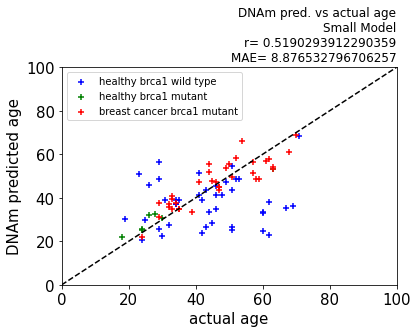

In [75]:
plt.scatter(y_brca1_arr[brca_c0_ind], small_brca1_age[brca_c0_ind], label= "healthy brca1 wild type", marker= "+", color= "blue")
plt.scatter(y_brca1_arr[brca_c1_ind], small_brca1_age[brca_c1_ind], color= "green", label= "healthy brca1 mutant", marker= "+")
plt.scatter(y_brca1_arr[brca_c2_ind], small_brca1_age[brca_c2_ind], color= "red", label= "breast cancer brca1 mutant", marker= "+")

small_brca1_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_test")
finalize_scatter_plot(y_brca1_arr, small_brca1_age, "Small Model", small_brca1_file_name)

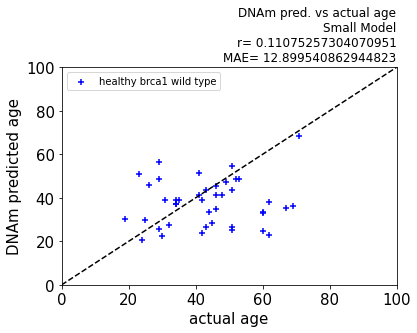

In [76]:
plt.scatter(y_brca1_arr[brca_c0_ind], small_brca1_age[brca_c0_ind], label= "healthy brca1 wild type", marker= "+", color= "blue")

small_brca1_healthy_wild_type_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_healthy_wild_type_test")
finalize_scatter_plot(y_brca1_arr[brca_c0_ind], small_brca1_age[brca_c0_ind], "Small Model",
                      small_brca1_healthy_wild_type_file_name)

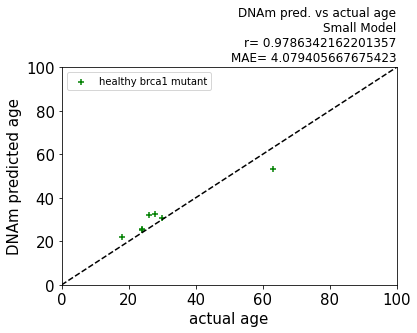

In [77]:
plt.scatter(y_brca1_arr[brca_c1_ind], small_brca1_age[brca_c1_ind], color= "green", label= "healthy brca1 mutant", marker= "+")

small_brca1_healthy_mutant_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_healthy_mutant_test")
finalize_scatter_plot(y_brca1_arr[brca_c1_ind], small_brca1_age[brca_c1_ind], "Small Model",
                      small_brca1_healthy_mutant_file_name)

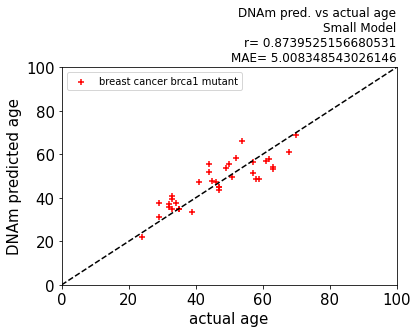

In [78]:
plt.scatter(y_brca1_arr[brca_c2_ind], small_brca1_age[brca_c2_ind], color= "red", label= "breast cancer brca1 mutant", marker= "+")
small_brca1_cancer_mutant_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_cancer_mutant_test")
finalize_scatter_plot(y_brca1_arr[brca_c2_ind], small_brca1_age[brca_c2_ind], "Small Model",
                      small_brca1_cancer_mutant_file_name)

In [79]:
# X_brca1 is a 28k dataset so we can't test with our Medium Model

## HIV set

In [80]:
HIV_male_data = ["GSE53840"]

In [81]:
X_HIV, y_HIV = process_data(HIV_male_data)

In [82]:
X_HIV["age"] = y_HIV

In [83]:
# we need to filter for missing ages (they default to 0)
X_HIV = X_HIV[X_HIV["age"] != 0.0]

row_keep = [a != 0.0 for a in y_HIV]
y_HIV = np.array(y_HIV)[row_keep]

In [84]:
X_HIV.drop(labels= "age", axis= "columns", inplace= True)

In [85]:
X_HIV.head(4)

ID_REF               cg00000029  cg00000108  cg00000109  cg00000165  \
GSE53840 GSM1301871    0.424289    0.930399    0.830893    0.340161   
         GSM1301872    0.591058    0.917798    0.834512    0.366086   
         GSM1301873    0.545455    0.904169    0.800456    0.379825   
         GSM1301874    0.485343    0.928916    0.821711    0.295978   

ID_REF               cg00000236  cg00000289  cg00000292  cg00000321  \
GSE53840 GSM1301871    0.725072    0.600667    0.831663    0.408293   
         GSM1301872    0.742132    0.550339    0.805495    0.285659   
         GSM1301873    0.684540    0.563581    0.805165    0.309745   
         GSM1301874    0.619807    0.589676    0.789118    0.288863   

ID_REF               cg00000363  cg00000622  ...  cg27665767  cg27665769  \
GSE53840 GSM1301871    0.488906    0.034326  ...    0.388448    0.387542   
         GSM1301872    0.486490    0.026814  ...    0.479168    0.358882   
         GSM1301873    0.334252    0.028865  ...    0.449645    0.422811   
         GSM1301874    0.359756    0.023670  ...    0.365971    0.385711   

ID_REF               cg27665808  cg27665823  cg27665829  cg27665860  \
GSE53840 GSM1301871    0.699722    0.934399    0.864611    0.815491   
         GSM1301872    0.616102    0.929681    0.822570    0.845937   
         GSM1301873    0.587324    0.938189    0.811546    0.832136   
         GSM1301874    0.650956    0.943028    0.808709    0.837675   

ID_REF               cg27665925  cg27665985  cg27666046  cg27666123  
GSE53840 GSM1301871    0.061597    0.399162    0.512386    0.723583  
         GSM1301872    0.053814    0.260563    0.682825    0.774066  
         GSM1301873    0.047101    0.235056    0.761953    0.825112  
         GSM1301874    0.052208    0.228265    0.738161    0.800497  

[4 rows x 482421 columns]

### Testing the Small Model

In [86]:
X_HIV_small = X_HIV[small_CpG_list]

In [87]:
X_HIV_small = small_scaler.transform(X_HIV_small)

In [88]:
small_HIV_age_pred = small_model.predict(X_HIV_small)

In [89]:
small_HIV_age_pred = np.array(small_HIV_age_pred)

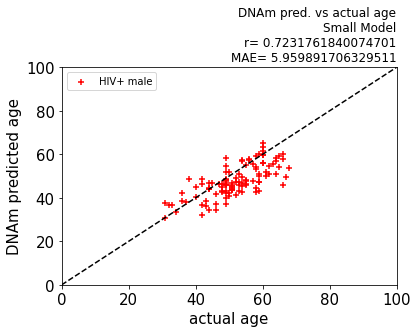

In [90]:
plt.scatter(y_HIV, small_HIV_age_pred, label= "HIV+ male", marker= "+", color= "red")
small_HIV_file_name = os.path.join(FIGURES_DIR, "small_model_HIV_test")
finalize_scatter_plot(y_HIV, small_HIV_age_pred, "Small Model", small_HIV_file_name)

### Testing the Medium Model

In [91]:
X_HIV_medium = X_HIV[medium_CpG_list]

In [92]:
X_HIV_medium = medium_scaler.transform(X_HIV_medium)

In [93]:
age_pred_HIV_medium = medium_model.predict(X_HIV_medium)

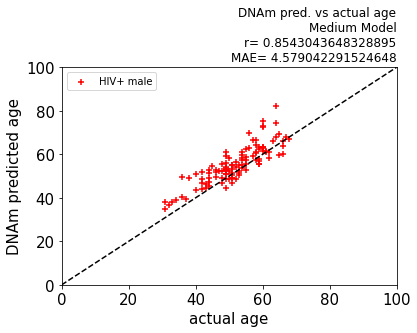

In [94]:
plt.scatter(y_HIV, age_pred_HIV_medium, label= "HIV+ male", marker= "+", color= "red")
medium_HIV_file_name = os.path.join(FIGURES_DIR, "medium_HIV_test")
finalize_scatter_plot(y_HIV, age_pred_HIV_medium, "Medium Model", medium_HIV_file_name)

In [95]:
hiv_pred_results_dict = {'actual age': y_HIV, 'predicted': age_pred_HIV_medium}
hiv_pred_results_dataframe = pd.DataFrame(data=hiv_pred_results_dict)
hiv_pred_results_dataframe.to_csv('medium_model_hiv_pred_results.csv')
hiv_pred_results_dataframe

,actual age,predicted
0,54.0,58.169125
1,61.0,61.092996
2,51.0,55.134134
3,49.0,52.148844
4,60.0,62.704102
...,...,...
106,51.0,48.943051
107,46.0,51.887988
108,31.0,34.891021
109,48.0,46.959073


## Rheumatoid arthritis

In [96]:
rheu_data = ["GSE42861"]

In [97]:
X_rheu, y_rheu = process_data(rheu_data)

In [98]:
_, rheu_stat = process_data(rheu_data, info= "arthritis")

In [99]:
arth_c0_ind = ["normal" == code for code in rheu_stat]
arth_c1_ind = ["rheumatoid arthritis" == code for code in rheu_stat]

In [100]:
del _

### Testing the Small Model

In [101]:
X_rheu_small = X_rheu[small_CpG_list]

In [102]:
X_rheu_small = small_scaler.transform(X_rheu_small)

In [103]:
small_rheu_age_pred = small_model.predict(X_rheu_small)

In [104]:
small_rheu_age_pred = np.array(small_rheu_age_pred)

In [105]:
y_rheu = np.array(y_rheu)

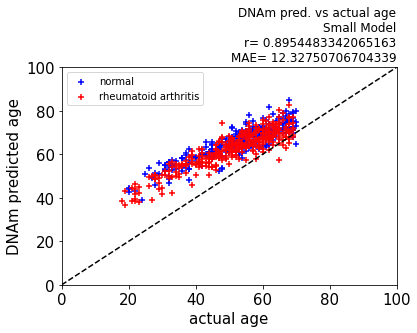

In [106]:
plt.scatter(y_rheu[arth_c0_ind], small_rheu_age_pred[arth_c0_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_rheu[arth_c1_ind], small_rheu_age_pred[arth_c1_ind], color= "red", label= "rheumatoid arthritis", marker= "+")
small_rheu_arthritis_file_name = os.path.join(FIGURES_DIR, "small_model_rheu_arthritis_test")
finalize_scatter_plot(y_rheu, small_rheu_age_pred, "Small Model", small_rheu_arthritis_file_name)

### Testing the Medium Model

In [107]:
X_rheu_medium = X_rheu[medium_CpG_list]

In [108]:
X_rheu_medium = medium_scaler.transform(X_rheu_medium)

In [109]:
medium_rheu_age_pred = medium_model.predict(X_rheu_medium)

In [110]:
y_rheu = np.array(y_rheu)

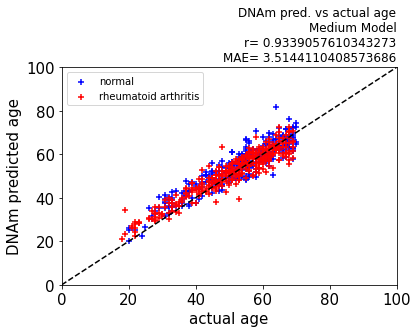

In [111]:
plt.scatter(y_rheu[arth_c0_ind], medium_rheu_age_pred[arth_c0_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_rheu[arth_c1_ind], medium_rheu_age_pred[arth_c1_ind], color= "red", label= "rheumatoid arthritis", marker= "+")
medium_rheu_arthritis_file_name = os.path.join(FIGURES_DIR, "medium_model_rheu_arthritis_test")
finalize_scatter_plot(y_rheu, medium_rheu_age_pred, "Medium Model", medium_rheu_arthritis_file_name)

In [112]:
arth_pred_results_dict = {'actual age': y_rheu, 'predicted': medium_rheu_age_pred}
arth_pred_results_dataframe = pd.DataFrame(data=arth_pred_results_dict)
arth_pred_results_dataframe.to_csv('medium_model_arthritis_pred_results.csv')
arth_pred_results_dataframe

,actual age,predicted
0,67.0,63.388053
1,49.0,48.675387
2,53.0,53.545823
3,62.0,61.957274
4,33.0,35.837680
...,...,...
684,63.0,61.154467
685,63.0,50.718656
686,46.0,46.616481
687,64.0,63.238491


## Crohn's disease

In [113]:
crohns_data = ["GSE32148"]

In [114]:
X_crohns, y_crohns = process_data(crohns_data)

In [115]:
# some samples are missing
X_crohns.shape

(48, 482421)

In [116]:
y_crohns[0]

49.0

In [117]:
_, crohns_stat = process_data(crohns_data, info= "crohns")

In [118]:
crohns_c0_ind = ["Crohn's" == code for code in crohns_stat]
crohns_c1_ind = ["normal" == code for code in crohns_stat]
crohns_c2_ind = ["ulcerative" == code for code in crohns_stat]

In [119]:
y_crohns_arr = np.array(y_crohns)

### Testing the Small Model

In [120]:
X_crohns_small = X_crohns[small_CpG_list]

In [121]:
X_crohns_small = small_scaler.transform(X_crohns_small)

In [122]:
small_crohns_age_pred = small_model.predict(X_crohns_small)

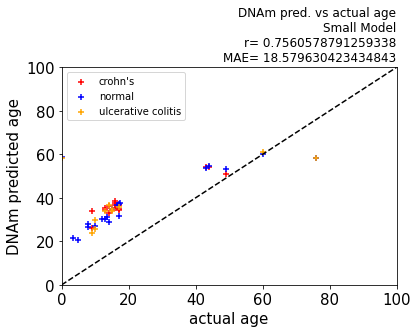

In [123]:
plt.scatter(y_crohns_arr[crohns_c0_ind], small_crohns_age_pred[crohns_c0_ind], color= "red", label= "crohn's", marker= "+")
plt.scatter(y_crohns_arr[crohns_c1_ind], small_crohns_age_pred[crohns_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_crohns_arr[crohns_c2_ind], small_crohns_age_pred[crohns_c2_ind], color= "orange", label= "ulcerative colitis", marker= "+")
small_crohns_file_name = os.path.join(FIGURES_DIR, "small_model_crohns_test")
finalize_scatter_plot(y_crohns_arr, small_crohns_age_pred, "Small Model", small_crohns_file_name)

### Testing the Medium Model

In [124]:
X_crohns_medium = X_crohns[medium_CpG_list]

In [125]:
X_crohns_medium = medium_scaler.transform(X_crohns_medium)

In [126]:
medium_crohns_age_pred = medium_model.predict(X_crohns_medium)

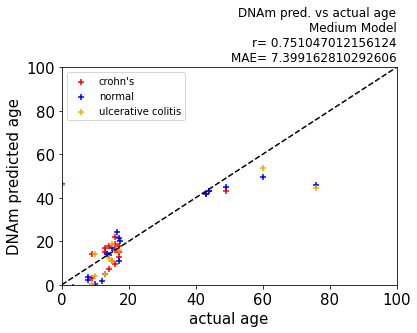

In [127]:
plt.scatter(y_crohns_arr[crohns_c0_ind], medium_crohns_age_pred[crohns_c0_ind], color= "red", label= "crohn's", marker= "+")
plt.scatter(y_crohns_arr[crohns_c1_ind], medium_crohns_age_pred[crohns_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_crohns_arr[crohns_c2_ind], medium_crohns_age_pred[crohns_c2_ind], color= "orange", label= "ulcerative colitis", marker= "+")
medium_crohns_file_name = os.path.join(FIGURES_DIR, "medium_model_crohns_test")
finalize_scatter_plot(y_crohns_arr, medium_crohns_age_pred, "Medium Model", medium_crohns_file_name)

## Down Syndrome

In [128]:
down_syn_data = ["GSE52588"]

In [129]:
X_ds, y_ds = process_data(down_syn_data)

In [130]:
X_ds["age"] = y_ds

In [131]:
y_ds = np.array(y_ds)

In [132]:
_, ds_status = process_data(down_syn_data, info= "down syndrome")

In [133]:
ds_c0_ind = ["Down" == code for code in ds_status]
ds_c1_ind = ["healthy" == code for code in ds_status]

### Testing the Small Model

In [134]:
X_ds_small = X_ds[small_CpG_list]

In [135]:
X_ds_small = small_scaler.transform(X_ds_small)

In [136]:
small_ds_age_pred = small_model.predict(X_ds_small)

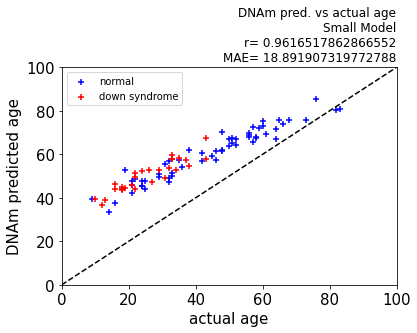

In [137]:
plt.scatter(y_ds[ds_c1_ind], small_ds_age_pred[ds_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_ds[ds_c0_ind], small_ds_age_pred[ds_c0_ind], color= "red", label= "down syndrome", marker= "+")
small_ds_file_name = os.path.join(FIGURES_DIR, "small_model_down_syndrome_test")
finalize_scatter_plot(y_ds, small_ds_age_pred, "Small Model", small_ds_file_name)

### Testing the Medium Model

In [138]:
X_ds_medium = X_ds[medium_CpG_list]

In [139]:
X_ds_medium = medium_scaler.transform(X_ds_medium)

In [140]:
medium_ds_age_pred = medium_model.predict(X_ds_medium)

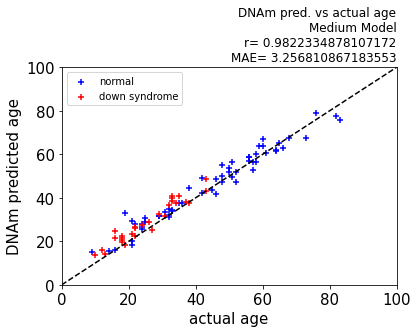

In [141]:
plt.scatter(y_ds[ds_c1_ind], medium_ds_age_pred[ds_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_ds[ds_c0_ind], medium_ds_age_pred[ds_c0_ind], color= "red", label= "down syndrome", marker= "+")
medium_ds_file_name = os.path.join(FIGURES_DIR, "medium_model_test_down_syndrome")
finalize_scatter_plot(y_ds, medium_ds_age_pred, "Medium Model", medium_ds_file_name)

In [142]:
down_pred_results_dict = {'actual age': y_ds, 'predicted': medium_ds_age_pred}
down_pred_results_dataframe = pd.DataFrame(data=down_pred_results_dict)
down_pred_results_dataframe.to_csv('medium_model_down_pred_results.csv')
down_pred_results_dataframe

,actual age,predicted
0,18.0,19.692359
1,12.0,15.796934
2,13.0,14.171253
3,24.0,27.328441
4,33.0,39.973312
...,...,...
82,66.0,62.791575
83,60.0,66.898740
84,68.0,67.545225
85,48.0,47.275391


## Test of Small Model on Medium Model's data

In [143]:
medium_X_small_test = medium_X[small_CpG_list]
medium_X_small_test = small_scaler.transform(medium_X_small_test)
small_prediction_on_medium_X = small_model.predict(medium_X_small_test)

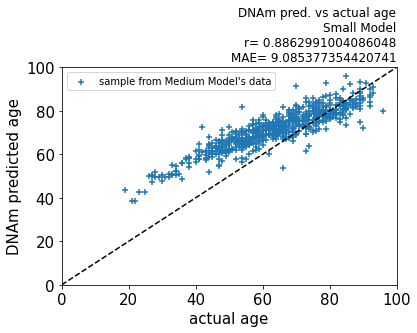

In [144]:
plt.scatter(medium_age, small_prediction_on_medium_X, marker= "+", label= "sample from Medium Model's data")
small_model_test_on_medium_X_file_name = os.path.join(FIGURES_DIR, "small_model_test_on_medium_X")
finalize_scatter_plot(medium_age, small_prediction_on_medium_X, "Small Model", small_model_test_on_medium_X_file_name)

## Predicting US population from birth year

In [145]:
us_population_per_year = pd.read_csv("colin-us-population.csv")
us_population_per_year

,year,population
0,1910,92228531
1,1911,93607835
2,1912,94987138
3,1913,96366442
4,1914,97745746
...,...,...
106,2016,322367784
107,2017,324638158
108,2018,326908532
109,2019,329178907


In [146]:
us_population_per_year["factor_reduced_population"] = us_population_per_year["population"] / 100_000_000
us_population_per_year

,year,population,factor_reduced_population
0,1910,92228531,0.922285
1,1911,93607835,0.936078
2,1912,94987138,0.949871
3,1913,96366442,0.963664
4,1914,97745746,0.977457
...,...,...,...
106,2016,322367784,3.223678
107,2017,324638158,3.246382
108,2018,326908532,3.269085
109,2019,329178907,3.291789


In [147]:
year_to_us_population_tuple = zip(us_population_per_year.loc[:, "year"], us_population_per_year.loc[:, "factor_reduced_population"])
year_to_us_population_dict = dict(year_to_us_population_tuple)
year_to_us_population_dict

{1910: 0.92228531,
 1911: 0.93607835,
 1912: 0.94987138,
 1913: 0.96366442,
 1914: 0.97745746,
 1915: 0.9912505,
 1916: 1.00504353,
 1917: 1.01883657,
 1918: 1.03262961,
 1919: 1.04642264,
 1920: 1.06021568,
 1921: 1.07739677,
 1922: 1.09457786,
 1923: 1.11175896,
 1924: 1.12894005,
 1925: 1.14612114,
 1926: 1.16330223,
 1927: 1.18048332,
 1928: 1.19766442,
 1929: 1.21484551,
 1930: 1.2320266,
 1931: 1.24098907,
 1932: 1.24995154,
 1933: 1.25891401,
 1934: 1.26787648,
 1935: 1.27683895,
 1936: 1.28580141,
 1937: 1.29476388,
 1938: 1.30372635,
 1939: 1.31268882,
 1940: 1.32165129,
 1941: 1.34081196,
 1942: 1.35997263,
 1943: 1.3791333,
 1944: 1.39829397,
 1945: 1.41745464,
 1946: 1.4366153,
 1947: 1.45577597,
 1948: 1.47493664,
 1949: 1.49409731,
 1950: 1.51325798,
 1951: 1.54125536,
 1952: 1.56925273,
 1953: 1.59725011,
 1954: 1.62524749,
 1955: 1.65324487,
 1956: 1.68124224,
 1957: 1.70923962,
 1958: 1.737237,
 1959: 1.76523437,
 1960: 1.79323175,
 1961: 1.8171205,
 1962: 1.84100925,


In [148]:
def get_us_population_from_birth_year(y_age, year_published):
    population_from_birth_years = np.zeros(len(y_age))
    
    index_counter = 0
    for age in y_age:
        birth_year = year_published - round(age)
        us_population = year_to_us_population_dict[birth_year]
        population_from_birth_years[index_counter] = us_population
        index_counter += 1
        
    return population_from_birth_years

In [149]:
medium_data = ["GSE40279"]

In [150]:
medium_X, medium_age = process_data(medium_data)

In [151]:
medium_X = medium_X[medium_CpG_list]
len(medium_X.columns)

438866

In [152]:
gse40279_publish_year = 2012
medium_us_population_at_birth = get_us_population_from_birth_year(medium_age, gse40279_publish_year)
medium_us_population_at_birth

array([1.41745464, 1.11175896, 1.4366153 , 1.47493664, 1.51325798,
       1.14612114, 1.31268882, 1.29476388, 1.31268882, 1.21484551,
       1.2320266 , 1.88878675, 1.27683895, 1.737237  , 1.49409731,
       1.34081196, 1.39829397, 1.24995154, 1.06021568, 1.56925273,
       1.25891401, 1.39829397, 1.04642264, 1.19766442, 1.30372635,
       1.30372635, 1.28580141, 1.68124224, 1.32165129, 1.29476388,
       1.25891401, 1.31268882, 1.2320266 , 1.30372635, 1.25891401,
       1.737237  , 0.93607835, 1.25891401, 1.19766442, 1.18048332,
       1.14612114, 1.30372635, 1.27683895, 1.31268882, 1.14612114,
       1.18048332, 1.12894005, 1.4366153 , 1.26787648, 1.76523437,
       1.28580141, 1.41745464, 1.31268882, 1.737237  , 1.31268882,
       1.00504353, 1.65324487, 1.28580141, 1.91267551, 1.737237  ,
       1.31268882, 1.19766442, 1.51325798, 1.11175896, 1.39829397,
       1.51325798, 1.25891401, 1.32165129, 1.3791333 , 1.70923962,
       1.31268882, 1.25891401, 1.32165129, 1.11175896, 1.25891

In [153]:
pop_model_scaler = StandardScaler()

In [154]:
medium_X_train, medium_X_test, medium_us_population_at_birth_train, medium_us_population_at_birth_test = train_test_split(medium_X, medium_us_population_at_birth, test_size= 0.20)

In [155]:
medium_X_train = pop_model_scaler.fit_transform(medium_X_train)
medium_X_test = pop_model_scaler.transform(medium_X_test)

In [156]:
len(medium_X_test)

132

In [157]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# medium_model = model.ElasticNetCV(l1_ratio= [0.5, 0.7, 0.85, 0.9, 0.95, 0.97, 0.99], selection= "random")
# medium_model.fit(medium_X_train, medium_us_population_at_birth_train)

# alpha= 0.06470723076032536
# l1_ratio= 0.2


pop_model = model.ElasticNet(alpha= 0.06470723076032536, l1_ratio= 0.2)
pop_model.fit(medium_X_train, medium_us_population_at_birth_train)

ElasticNet(alpha=0.06470723076032536, l1_ratio=0.2)

In [158]:
def get_number_of_non_zero_coef(model):
    all_coef = model.coef_
    num_non_zero_coef = 0
    for c in all_coef:
        if c != 0:
            num_non_zero_coef += 1
    return num_non_zero_coef

In [159]:
def get_number_of_sizeable_coef(model):
    all_coef = model.coef_
    num_sizeable_coef = 0
    for c in all_coef:
        if abs(c) > 0.1:
            num_sizeable_coef += 1
    return num_sizeable_coef

In [160]:
get_number_of_non_zero_coef(pop_model)

139

In [161]:
get_number_of_sizeable_coef(pop_model)

0

In [162]:
len(pop_model.coef_)

438866

In [163]:
medium_X_test_predict = pop_model.predict(medium_X_test)
medium_X_test_predict

array([1.18878995, 1.67029122, 2.51694084, 1.4756547 , 1.31472497,
       1.67777836, 1.15721725, 1.63710242, 1.8541407 , 1.60420535,
       1.43269586, 1.54711807, 1.73819916, 1.70530129, 1.54529454,
       1.33873035, 1.58453039, 1.31906065, 1.55916423, 1.66539396,
       2.22446208, 1.61544383, 1.39946592, 1.28207609, 1.22763063,
       1.38477382, 1.98546439, 1.3137175 , 1.82259989, 1.30027012,
       1.066671  , 1.23881432, 1.55892056, 1.4952149 , 1.67964686,
       1.60364731, 1.77591136, 2.20813685, 1.41990066, 1.39575203,
       1.32040978, 2.25163065, 1.49285114, 1.44349711, 1.22612019,
       1.53561833, 1.70979525, 1.74579705, 1.1910548 , 1.70506274,
       1.81881056, 1.90386957, 1.2859204 , 1.90659338, 1.71743568,
       1.63045137, 1.53852081, 1.14739978, 1.76274466, 1.58681292,
       1.55193771, 1.27783717, 1.20185961, 1.56552753, 1.47224308,
       1.74731312, 1.80105703, 1.91104439, 1.32442442, 1.45617213,
       1.54138499, 1.84603999, 2.48509207, 1.0142738 , 1.25006

In [164]:
def finalize_scatter_plot_for_us_population(x, y, model_name, file_name, num_cpgs):
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    
    title_config = {'fontsize': 10,
                    'fontweight' : 10,
                    'verticalalignment': 'baseline',
                    'horizontalalignment': "right"}

    plt.title(f"DNAm pred. US population at birth vs actual US population at birth {model_name}\nNumber of non-zero CpG weights: {num_cpgs}\nr= {r}\nMAE= {mae_val} (in hundred-millions)", fontdict= title_config, loc= "right")
    
    axis_buffer = 0.3
    
    max_x = max(x)
    max_y = max(y)
    axis_limit = max(max_x, max_y) + axis_buffer
    
    accuracy_line = [0, axis_limit]
    
    min_x = min(x)
    min_y = min(y)
    axis_floor = min(min_x, min_y) - axis_buffer
    
    plt.xlim(axis_floor, axis_limit)
    plt.ylim(axis_floor, axis_limit)
    
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("actual US population\nat birth (in hundred-millions)", fontsize= 9)
    plt.ylabel("DNAm predicted US population\nat birth (in hundred-millions)", fontsize= 9)
    
    plt.legend()
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

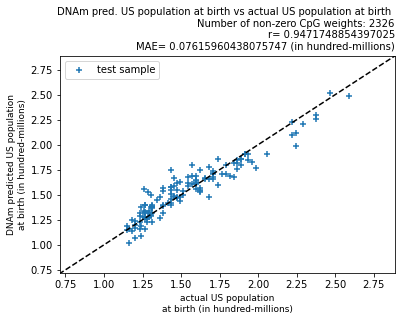

In [165]:
num_non_zero_cpgs = get_number_of_non_zero_coef(medium_model)
plt.scatter(medium_us_population_at_birth_test, medium_X_test_predict, label= "test sample", marker= "+")
us_population_file_name = os.path.join(FIGURES_DIR, "us_population_on_GSE40279_factor_reduced")
finalize_scatter_plot_for_us_population(
    medium_us_population_at_birth_test, 
    medium_X_test_predict, 
    "", 
    us_population_file_name,
    num_non_zero_cpgs
)

In [166]:
us_pop_cpgs_indices = set(get_non_zero_cpgs_indices(pop_model))

### Now to use these US population CpGs as a pre-filter for the age model

In [167]:
filtered_cpgs = us_pop_cpgs_indices

In [168]:
len(filtered_cpgs)

139

#### now let us select only these CpGs from our array to feed into a population model

In [169]:
medium_data = ["GSE40279"]

In [170]:
medium_X, medium_age = process_data(medium_data)

In [171]:
medium_X = medium_X[medium_CpG_list]
len(medium_X.columns)

438866

In [172]:
filtered_cpgs_ints = []
for cpg in filtered_cpgs:
    filtered_cpgs_ints.append(int(cpg))
len(filtered_cpgs_ints)

139

In [173]:
medium_X_pop_cpgs = medium_X.iloc[:, filtered_cpgs_ints]
len(medium_X_pop_cpgs.columns)

139

#### and rebuild the model as normal

In [174]:
medium_us_pop_cpgs_scaler = StandardScaler()

In [175]:
medium_X_pop_cpgs_train, medium_X_pop_cpgs_test, medium_age_pop_cpgs_train, medium_age_pop_cpgs_test = train_test_split(medium_X_pop_cpgs, medium_age, test_size= 0.20)

In [176]:
medium_X_pop_cpgs_train = medium_us_pop_cpgs_scaler.fit_transform(medium_X_pop_cpgs_train)
medium_X_pop_cpgs_test = medium_us_pop_cpgs_scaler.transform(medium_X_pop_cpgs_test)

In [177]:
medium_model_pop_cpgs = model.ElasticNetCV(
    l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], 
    selection= "random"
)
medium_model_pop_cpgs.fit(medium_X_pop_cpgs_train, medium_age_pop_cpgs_train)

ElasticNetCV(l1_ratio=[0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99],
             selection='random')

In [178]:
medium_model_pop_cpgs.alpha_

0.40411061078475397

In [179]:
medium_model_pop_cpgs.l1_ratio_

0.05

In [180]:
get_number_of_non_zero_coef(medium_model_pop_cpgs)

136

In [181]:
medium_X_pop_cpgs_test_predict = medium_model_pop_cpgs.predict(medium_X_pop_cpgs_test)

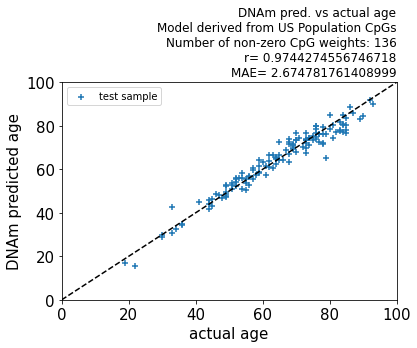

In [182]:
plt.scatter(medium_age_pop_cpgs_test, medium_X_pop_cpgs_test_predict, label= "test sample", marker= "+")
medium_pop_cpgs_file_name = os.path.join(FIGURES_DIR, "medium_model_us_pop_filtered")
non_zero_cpg_weights = get_number_of_non_zero_coef(medium_model_pop_cpgs)
finalize_scatter_plot(
    medium_age_pop_cpgs_test,
    medium_X_pop_cpgs_test_predict,
    f"Model derived from US Population CpGs\nNumber of non-zero CpG weights: {non_zero_cpg_weights}", 
    medium_pop_cpgs_file_name
)

### Now let's make a prediction on our Down Syndrome set

In [183]:
down_syn_data = ["GSE52588"]

In [184]:
X_ds, y_ds = process_data(down_syn_data)

In [185]:
X_ds = X_ds[medium_CpG_list]
len(medium_X.columns)

438866

In [186]:
X_ds = X_ds.iloc[:, filtered_cpgs_ints]
len(X_ds.columns)

139

In [187]:
_, ds_status = process_data(down_syn_data, info= "down syndrome")

In [188]:
ds_c0_ind = ["Down" == code for code in ds_status]
ds_c1_ind = ["healthy" == code for code in ds_status]

In [189]:
X_ds = medium_us_pop_cpgs_scaler.transform(X_ds)

In [190]:
medium_pop_cpgs_ds_age_pred = medium_model_pop_cpgs.predict(X_ds)

In [191]:
y_ds = np.array(y_ds)

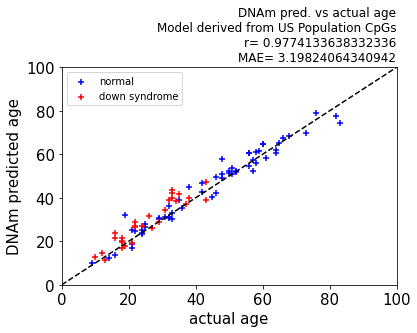

In [192]:
del X_ds

plt.scatter(y_ds[ds_c1_ind], medium_pop_cpgs_ds_age_pred[ds_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_ds[ds_c0_ind], medium_pop_cpgs_ds_age_pred[ds_c0_ind], color= "red", label= "down syndrome", marker= "+")
medium_pop_cpgs_ds_file_name = os.path.join(FIGURES_DIR, "medium_model_test_down_syndrome_us_pop_cpgs")
finalize_scatter_plot(
    y_ds, 
    medium_pop_cpgs_ds_age_pred, 
    "Model derived from US Population CpGs", 
    medium_pop_cpgs_ds_file_name
)

In [193]:
d = {"pred_age": medium_pop_cpgs_ds_age_pred, "actual_age": y_ds}
d

{'pred_age': array([20.12341466, 14.81868261, 11.39465377, 27.26487144, 40.07461884,
        34.41592383, 17.96422952, 29.05835791, 26.58650719, 39.74963079,
        38.3768069 , 37.03728792, 12.59675174, 43.46108865, 41.76591359,
        19.71757392, 23.6074981 , 16.90572895, 26.13389253, 39.17620902,
        42.04985169, 28.91903194, 21.4900089 , 19.29953236, 39.00908978,
        31.43783682, 47.08455494, 21.4840478 , 27.11495675, 25.42692496,
        24.5776739 , 10.16200402, 18.65356648, 47.00311283, 25.40523367,
        27.82591197, 23.62049558, 32.99229482, 52.11394021, 30.55729242,
        42.23695198, 30.92832105, 35.4350293 , 31.30220318, 13.80571173,
        16.70042093, 23.56144821, 30.26313958, 50.74459469, 52.07985591,
        36.30151746, 26.64802951, 32.21300809, 39.1995477 , 30.18055291,
        44.83978738, 12.11685101, 31.15062731, 51.30478967, 51.02737763,
        42.82124226, 57.35227066, 65.17936788, 60.74972629, 58.02185203,
        53.62422716, 60.58789445, 74.29

In [194]:
ds_results = pd.DataFrame(data= d)
ds_results

,pred_age,actual_age
0,20.123415,18.0
1,14.818683,12.0
2,11.394654,13.0
3,27.264871,24.0
4,40.074619,33.0
...,...,...
82,67.346310,66.0
83,64.906310,60.0
84,68.402882,68.0
85,49.084507,48.0


In [195]:
ds_results.to_csv("./down_syndrome_results_gen_2.csv")

### Let's do the same for our Arthritis set

In [196]:
arth_data = ["GSE42861"]

In [197]:
X_arth, y_rheu = process_data(arth_data)

In [198]:
X_arth = X_arth[medium_CpG_list]
len(medium_X.columns)

438866

In [199]:
X_arth = X_arth.iloc[:, filtered_cpgs_ints]
len(X_arth.columns)

139

In [200]:
_, rheu_stat = process_data(arth_data, info= "arthritis")

In [201]:
arth_c0_ind = ["normal" == code for code in rheu_stat]
arth_c1_ind = ["rheumatoid arthritis" == code for code in rheu_stat]

In [202]:
X_arth = medium_us_pop_cpgs_scaler.transform(X_arth)

In [203]:
medium_pop_cpgs_arth_age_pred = medium_model_pop_cpgs.predict(X_arth)

In [204]:
y_rheu = np.array(y_rheu)

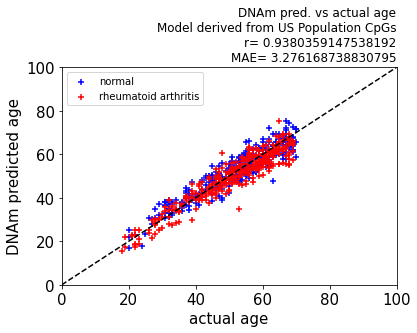

In [205]:
del X_arth

plt.scatter(y_rheu[arth_c0_ind], medium_pop_cpgs_arth_age_pred[arth_c0_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_rheu[arth_c1_ind], medium_pop_cpgs_arth_age_pred[arth_c1_ind], color= "red", label= "rheumatoid arthritis", marker= "+")
medium_rheu_pop_cpgs_arthritis_file_name = os.path.join(FIGURES_DIR, "medium_model_us_pop_cpgs_rheu_arthritis_test")
finalize_scatter_plot(
    y_rheu, 
    medium_pop_cpgs_arth_age_pred, 
    "Model derived from US Population CpGs", 
    medium_rheu_pop_cpgs_arthritis_file_name
)

In [206]:
d = {"pred_age": medium_pop_cpgs_arth_age_pred, "actual_age": y_rheu}
d

{'pred_age': array([63.81024982, 49.03493057, 53.89799605, 60.43046419, 34.41556982,
        61.56160028, 68.75306443, 54.11645388, 65.55468838, 44.60417511,
        36.58968354, 61.5320145 , 49.02887598, 45.20919035, 65.59042162,
        63.66380674, 64.53333669, 57.82107768, 51.93235435, 57.59882942,
        52.74599296, 49.51349418, 53.74693337, 53.49710848, 47.27748808,
        57.99016746, 66.11000442, 59.39530657, 60.94425419, 48.92391185,
        64.26249562, 54.96382247, 55.67351443, 31.18449355, 60.50133027,
        53.03808109, 64.12224694, 57.17703406, 33.14209515, 55.60416071,
        48.48535652, 47.70242149, 42.09329002, 46.02600022, 36.44030401,
        59.38302395, 35.17881573, 64.59812265, 43.70288702, 58.33224907,
        49.57768768, 37.13024004, 49.70355934, 54.54551397, 47.8718146 ,
        63.7988767 , 62.31254145, 52.85973244, 57.06095733, 60.44326573,
        60.84955755, 65.85217701, 54.86154727, 58.71143147, 41.69651735,
        30.79620997, 45.04924045, 40.94

In [207]:
ds_results = pd.DataFrame(data= d)
ds_results

,pred_age,actual_age
0,63.810250,67.0
1,49.034931,49.0
2,53.897996,53.0
3,60.430464,62.0
4,34.415570,33.0
...,...,...
684,60.418780,63.0
685,47.824468,63.0
686,47.036221,46.0
687,62.629186,64.0


In [208]:
ds_results.to_csv("./arthritis_results_gen_2.csv")

### Let's do the same for the HIV set

In [209]:
X_HIV_medium = X_HIV[medium_CpG_list]

In [210]:
X_HIV_medium = X_HIV_medium.iloc[:, filtered_cpgs_ints]
len(X_HIV_medium.columns)

139

In [211]:
X_HIV_medium = medium_us_pop_cpgs_scaler.transform(X_HIV_medium)

In [212]:
age_pred_HIV_medium_pop_cpgs = medium_model_pop_cpgs.predict(X_HIV_medium)

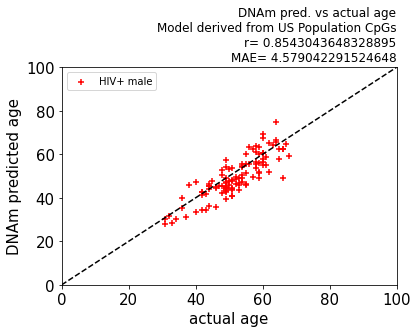

In [213]:
plt.scatter(y_HIV, age_pred_HIV_medium_pop_cpgs, label= "HIV+ male", marker= "+", color= "red")
medium_HIV_file_name = os.path.join(FIGURES_DIR, "medium_HIV_test_us_pop_derived")
finalize_scatter_plot(y_HIV, age_pred_HIV_medium, "Model derived from US Population CpGs", medium_HIV_file_name)

### Now for the Werner Syndrome dataset

In [214]:
werner_file = open("./Werner_Syndrome.pickle", mode= "rb")

In [215]:
werner_df = pickle.load(werner_file)
werner_df

ID_REF                cg00000029  cg00000103  cg00000109  cg00000155  \
GSE100825 GSM2694066    0.646562    0.878838    0.905579    0.925186   
          GSM2694067    0.538249    0.902410    0.904032    0.934665   
          GSM2694068    0.527190    0.898359    0.885479    0.925673   
          GSM2694069    0.516348    0.884633    0.882224    0.920914   
          GSM2694070    0.421783    0.877394    0.884108    0.903828   
          GSM2694071    0.563347    0.877676    0.902442    0.930035   

ID_REF                cg00000158  cg00000165  cg00000221  cg00000236  \
GSE100825 GSM2694066    0.932245    0.106970    0.861418    0.761809   
          GSM2694067    0.935280    0.113383    0.886281    0.785804   
          GSM2694068    0.941409    0.150861    0.866107    0.832197   
          GSM2694069    0.937409    0.059281    0.887977    0.712423   
          GSM2694070    0.932568    0.095332    0.872783    0.737723   
          GSM2694071    0.912951    0.124959    0.901731    0.752412   

ID_REF                cg00000289  cg00000292  ...  cg27665913  cg27665925  \
GSE100825 GSM2694066    0.778761    0.811275  ...    0.900759    0.011261   
          GSM2694067    0.777328    0.815536  ...    0.918351    0.012891   
          GSM2694068    0.737792    0.836610  ...    0.910301    0.012986   
          GSM2694069    0.834136    0.788549  ...    0.897614    0.012966   
          GSM2694070    0.791135    0.841383  ...    0.921618    0.012990   
          GSM2694071    0.797080    0.806697  ...    0.920886    0.012712   

ID_REF                cg27665978  cg27665985  cg27666046  cg27666049  \
GSE100825 GSM2694066    0.844620    0.244657    0.564599    0.868386   
          GSM2694067    0.859105    0.341572    0.555774    0.816575   
          GSM2694068    0.834268    0.404887    0.388906    0.841959   
          GSM2694069    0.876654    0.250914    0.710208    0.844317   
          GSM2694070    0.862241    0.274147    0.572511    0.891965   
          GSM2694071    0.860147    0.265730    0.579267    0.890517   

ID_REF                cg27666060  cg27666108  cg27666123   age  
GSE100825 GSM2694066    0.824801    0.233204    0.839785  51.0  
          GSM2694067    0.831095    0.270234    0.863915  44.0  
          GSM2694068    0.825738    0.293093    0.796659  53.0  
          GSM2694069    0.873103    0.244478    0.852989  53.0  
          GSM2694070    0.828678    0.248083    0.849475  44.0  
          GSM2694071    0.847140    0.312648    0.882008  52.0  

[6 rows x 863905 columns]

In [216]:
werner_ages = np.array(werner_df["age"])

In [217]:
werner_df = werner_df[medium_CpG_list]

In [218]:
werner_df = werner_df.iloc[:, filtered_cpgs_ints]
len(werner_df.columns)

139

In [219]:
werner_df = werner_df.fillna(method= "pad")

In [220]:
werner_df = medium_us_pop_cpgs_scaler.transform(werner_df)
werner_df

array([[-5.59193482e-02, -6.68781891e-01, -2.20937243e+00,
         1.01692002e-01, -4.22896453e-01,  3.85103876e-01,
        -1.25554224e+00, -9.31586883e-01, -1.27953998e+00,
         1.89719945e-01, -1.52722416e+00, -1.16295249e+00,
        -2.15683944e-01, -4.44082488e-01, -1.20244042e+00,
        -2.01530516e+00, -2.79090429e+00,  8.04864352e-01,
        -6.78459671e-01, -2.14742197e+00, -1.25716785e+00,
        -1.71030493e+00, -7.56192936e-01, -1.76079878e+00,
         2.21230509e-01, -2.54183610e+00, -1.28128443e+00,
        -1.81931737e+00,  2.30304670e+00, -8.35798289e-01,
        -2.05598481e+00,  7.11474466e-01, -9.18792437e-01,
        -1.46787404e+00, -1.61270491e+00, -5.67199363e-01,
         1.11479287e+00,  2.74786342e-02,  3.71278844e-01,
         5.43120164e-01,  3.61037558e-01, -2.10694800e+00,
        -5.33737052e-01,  1.28426074e+00, -1.48451369e+00,
        -1.00529029e-01, -4.54628005e-01, -1.85252289e+00,
        -1.55436664e+00, -4.64801652e-01, -2.68205406e+0

In [221]:
werner_age_pred_pop_cpgs = medium_model_pop_cpgs.predict(werner_df)

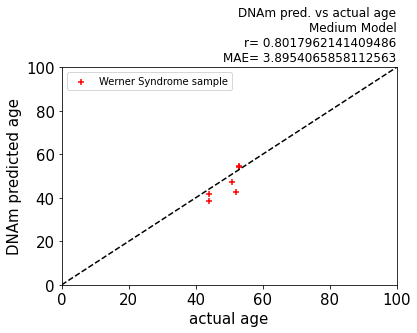

In [222]:
plt.scatter(werner_ages, werner_age_pred_pop_cpgs, label= "Werner Syndrome sample", marker= "+", color= "red")
werner_filename = os.path.join(FIGURES_DIR, "medium_model_werner_syndrome_test_gen_2")
finalize_scatter_plot(werner_ages, werner_age_pred_pop_cpgs, "Medium Model", werner_filename)

In [223]:
d = {"pred_age": werner_age_pred_pop_cpgs, "actual_age": werner_ages}
d

{'pred_age': array([47.41973977, 38.55659098, 54.32867836, 54.41313096, 41.78683242,
        42.60620664]),
 'actual_age': array([51., 44., 53., 53., 44., 52.])}

In [224]:
werner_results = pd.DataFrame(data= d)
werner_results

,pred_age,actual_age
0,47.419740,51.0
1,38.556591,44.0
2,54.328678,53.0
3,54.413131,53.0
4,41.786832,44.0
5,42.606207,52.0


In [225]:
werner_results.to_csv("./werner_syndrome_results_gen_2.csv")

### Now for IBS

In [226]:
# ibs_file = open("./IBS.pkl", mode= "rb")
ibs_file_dis = open("./GSE87640_IBS_D.pkl", mode= "rb")
ibs_file_h = open("GSE87640_IBS_H.pkl", mode= "rb")

In [227]:
ibs_dis_df = pickle.load(ibs_file_dis)
ibs_dis_df

ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873,status,Age,dataset
GSM2336832,0.549741,0.899432,0.795014,0.286338,0.767504,0.552438,0.828324,0.282016,0.365323,0.048341,...,0.070074,0.921308,0.613464,0.588418,0.509357,0.212338,0.849751,CD,42.1,ibs_dis
GSM2336834,0.547368,0.903526,0.763479,0.25635,0.755042,0.550666,0.846628,0.307893,0.377271,0.045629,...,0.946293,0.499156,0.629431,0.554334,0.520156,0.819954,0.813065,CD,63.7,ibs_dis
GSM2336840,0.541137,0.908998,0.788836,0.294226,0.770154,0.607374,0.826482,0.300216,0.386122,0.041238,...,0.0616,0.063069,0.601617,0.105412,0.086457,0.586673,0.854328,CD,27.9,ibs_dis
GSM2336852,0.59756,0.903197,0.801382,0.269748,0.75306,0.616921,0.816276,0.383757,0.3956,0.042647,...,0.540458,0.928244,0.621529,0.563496,0.921112,0.189469,0.651282,CD,33.4,ibs_dis
GSM2336854,0.530645,0.915744,0.821899,0.250332,0.686441,0.57417,0.826308,0.326487,0.390867,0.050703,...,0.532088,0.061821,0.89297,0.092066,0.535875,0.569426,0.675044,UC,31.3,ibs_dis
GSM2336870,0.524468,0.902584,0.769588,0.23916,0.744276,0.572952,0.814722,0.291636,0.359797,0.047613,...,0.947342,0.511328,0.55967,0.551385,0.076154,0.197215,0.876193,UC,38.0,ibs_dis
GSM2336878,0.577904,0.911579,0.795905,0.279599,0.787155,0.589451,0.853359,0.440465,0.420051,0.040874,...,0.57304,0.51065,0.168489,0.927134,0.519495,0.217318,0.690688,CD,30.3,ibs_dis
GSM2336880,0.540345,0.918125,0.834213,0.298378,0.739126,0.597246,0.824074,0.358834,0.390473,0.046747,...,0.532674,0.476525,0.594284,0.102987,0.533508,0.186428,0.888869,UC,24.3,ibs_dis
GSM2336882,0.434531,0.907832,0.777332,0.211037,0.740904,0.607416,0.787627,0.264827,0.35853,0.038514,...,0.533383,0.489815,0.886735,0.100844,0.524117,0.189785,0.821124,CD,36.8,ibs_dis
GSM2336886,0.511409,0.922535,0.801611,0.276704,0.734199,0.619285,0.82218,0.313293,0.361501,0.043993,...,0.533668,0.920555,0.884573,0.572438,0.090311,0.582564,0.669207,UC,50.7,ibs_dis


In [228]:
ibs_h_df = pickle.load(ibs_file_h)
ibs_h_df

ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873,status,Age,dataset
GSM2336819,0.549209,0.899991,0.757192,0.254714,0.782396,0.537098,0.826841,0.343745,0.383886,0.043136,...,0.942371,0.488452,0.855391,0.581672,0.92238,0.817588,0.797783,HC,30.8,ibs_nor
GSM2336827,0.519933,0.906677,0.706958,0.241028,0.74487,0.542393,0.821062,0.351254,0.371266,0.04357,...,0.944359,0.919438,0.844187,0.929128,0.920838,0.823921,0.760134,HC,30.7,ibs_nor
GSM2336833,0.5526,0.905726,0.805958,0.263665,0.739862,0.588939,0.834798,0.390893,0.372192,0.045892,...,0.539608,0.490323,0.876,0.585221,0.513731,0.590028,0.836758,HC,37.4,ibs_nor
GSM2336856,0.530775,0.913784,0.805319,0.269552,0.723078,0.559057,0.787647,0.324137,0.387651,0.043599,...,0.05715,0.506683,0.622407,0.087857,0.080931,0.587346,0.837334,HC,32.6,ibs_nor
GSM2336861,0.593118,0.91607,0.844119,0.27823,0.739794,0.667035,0.834277,0.363567,0.370392,0.048582,...,0.058063,0.925916,0.092894,0.55133,0.072281,0.517504,0.622348,HC,43.9,ibs_nor
GSM2336868,0.455952,0.908714,0.797681,0.261277,0.730909,0.581074,0.790828,0.28651,0.397466,0.043991,...,0.557242,0.064353,0.873529,0.09735,0.517884,0.589039,0.662025,HC,42.8,ibs_nor
GSM2336889,0.500527,0.904632,0.748776,0.314495,0.736437,0.596911,0.825962,0.395796,0.3945,0.041265,...,0.940942,0.503801,0.617354,0.095792,0.925177,0.538689,0.608477,HC,58.5,ibs_nor
GSM2336895,0.560051,0.913212,0.784053,0.285054,0.740693,0.586177,0.833921,0.314921,0.391418,0.044066,...,0.548987,0.927283,0.910739,0.095542,0.928673,0.172877,0.873935,HC,40.2,ibs_nor
GSM2336921,0.553901,0.928767,0.835018,0.250847,0.777824,0.666828,0.842244,0.30203,0.368054,0.03949,...,0.563419,0.926201,0.570277,0.918668,0.936847,0.152521,0.680486,HC,30.3,ibs_nor
GSM2336965,0.518886,0.940133,0.826656,0.293712,0.771659,0.620556,0.851709,0.313391,0.41303,0.04928,...,0.063632,0.062463,0.592172,0.620017,0.073737,0.169735,0.882153,HC,41.5,ibs_nor


In [229]:
ibs_df = pd.concat([ibs_dis_df, ibs_h_df])
ibs_df

ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873,status,Age,dataset
GSM2336832,0.549741,0.899432,0.795014,0.286338,0.767504,0.552438,0.828324,0.282016,0.365323,0.048341,...,0.070074,0.921308,0.613464,0.588418,0.509357,0.212338,0.849751,CD,42.1,ibs_dis
GSM2336834,0.547368,0.903526,0.763479,0.25635,0.755042,0.550666,0.846628,0.307893,0.377271,0.045629,...,0.946293,0.499156,0.629431,0.554334,0.520156,0.819954,0.813065,CD,63.7,ibs_dis
GSM2336840,0.541137,0.908998,0.788836,0.294226,0.770154,0.607374,0.826482,0.300216,0.386122,0.041238,...,0.0616,0.063069,0.601617,0.105412,0.086457,0.586673,0.854328,CD,27.9,ibs_dis
GSM2336852,0.59756,0.903197,0.801382,0.269748,0.75306,0.616921,0.816276,0.383757,0.3956,0.042647,...,0.540458,0.928244,0.621529,0.563496,0.921112,0.189469,0.651282,CD,33.4,ibs_dis
GSM2336854,0.530645,0.915744,0.821899,0.250332,0.686441,0.57417,0.826308,0.326487,0.390867,0.050703,...,0.532088,0.061821,0.89297,0.092066,0.535875,0.569426,0.675044,UC,31.3,ibs_dis
GSM2336870,0.524468,0.902584,0.769588,0.23916,0.744276,0.572952,0.814722,0.291636,0.359797,0.047613,...,0.947342,0.511328,0.55967,0.551385,0.076154,0.197215,0.876193,UC,38.0,ibs_dis
GSM2336878,0.577904,0.911579,0.795905,0.279599,0.787155,0.589451,0.853359,0.440465,0.420051,0.040874,...,0.57304,0.51065,0.168489,0.927134,0.519495,0.217318,0.690688,CD,30.3,ibs_dis
GSM2336880,0.540345,0.918125,0.834213,0.298378,0.739126,0.597246,0.824074,0.358834,0.390473,0.046747,...,0.532674,0.476525,0.594284,0.102987,0.533508,0.186428,0.888869,UC,24.3,ibs_dis
GSM2336882,0.434531,0.907832,0.777332,0.211037,0.740904,0.607416,0.787627,0.264827,0.35853,0.038514,...,0.533383,0.489815,0.886735,0.100844,0.524117,0.189785,0.821124,CD,36.8,ibs_dis
GSM2336886,0.511409,0.922535,0.801611,0.276704,0.734199,0.619285,0.82218,0.313293,0.361501,0.043993,...,0.533668,0.920555,0.884573,0.572438,0.090311,0.582564,0.669207,UC,50.7,ibs_dis


In [230]:
age_vals = ibs_df["Age"]

In [231]:
disease_state = ibs_df["status"]

In [232]:
cd_indices = []
hc_indices = []
uc_indices = []

In [233]:
for state in disease_state:
    if state == "CD":
        cd_indices.append(True)
        hc_indices.append(False)
        uc_indices.append(False)
        continue
        
    if state == "HC":
        cd_indices.append(False)
        hc_indices.append(True)
        uc_indices.append(False)
        continue
        
    if state == "UC":
        cd_indices.append(False)
        hc_indices.append(False)
        uc_indices.append(True)
        continue

In [234]:
len(cd_indices)

51

In [235]:
ibs_df = ibs_df.fillna(method= "pad")

In [236]:
ibs_df = ibs_df[medium_CpG_list]

In [237]:
ibs_df = ibs_df.iloc[:, filtered_cpgs_ints]
len(ibs_df.columns)

139

In [238]:
ibs_df.head()

ID_REF,cg02711397,cg16867657,cg01974375,cg08271909,cg11830800,cg27407385,cg18240400,cg19037555,cg17802949,cg07082267,...,cg17372101,cg08323969,cg05318503,cg18343474,cg17983814,cg17621438,cg11431402,cg10052840,cg11571588,cg04604946
GSM2336832,0.174148,0.571231,0.300001,0.918776,0.477953,0.910162,0.478446,0.133110,0.247155,0.446888,...,0.431251,0.362990,0.803329,0.192821,0.924678,0.339526,0.523000,0.553935,0.861843,0.472659
GSM2336834,0.215242,0.678640,0.239848,0.898955,0.611384,0.894416,0.527596,0.119590,0.269827,0.442079,...,0.504562,0.359895,0.792828,0.226969,0.948840,0.380771,0.538239,0.568017,0.871731,0.372103
GSM2336840,0.198562,0.503632,0.286072,0.907742,0.482118,0.903868,0.435191,0.126339,0.205817,0.500135,...,0.474092,0.355321,0.798100,0.168926,0.944121,0.386876,0.511933,0.604129,0.880234,0.426479
GSM2336852,0.277717,0.528342,0.255867,0.899088,0.611939,0.894656,0.506087,0.137988,0.194467,0.491189,...,0.434494,0.374636,0.798616,0.194646,0.935080,0.392134,0.509409,0.589337,0.870165,0.440348
GSM2336854,0.174321,0.510908,0.323515,0.894801,0.632505,0.895169,0.458582,0.132898,0.202008,0.477118,...,0.477794,0.358597,0.831870,0.168176,0.928817,0.394765,0.534710,0.564620,0.908892,0.419301


In [239]:
ibs_df = medium_us_pop_cpgs_scaler.transform(ibs_df)
ibs_df

array([[-0.11159276, -1.23190914,  2.68125078, ...,  0.53793357,
        -1.22442896,  3.90436757],
       [ 0.47409253,  0.12268254,  0.89879496, ...,  0.93249647,
        -0.79403977,  1.0063915 ],
       [ 0.23636427, -2.08443032,  2.2685046 , ...,  1.94434262,
        -0.4239302 ,  2.57347154],
       ...,
       [-0.65323858, -2.64574228,  2.70743198, ...,  2.96600908,
         0.36615363,  3.44131318],
       [-0.80246183, -2.31601575,  2.47027633, ...,  3.01471306,
         0.50705115,  2.76416033],
       [-0.71026026, -2.83102838,  2.97777296, ...,  3.3042462 ,
         0.8514919 ,  2.90103637]])

In [240]:
ibs_age_pred_us_pop = medium_model_pop_cpgs.predict(ibs_df)
ibs_age_pred_us_pop

array([41.6375683 , 64.64489046, 30.46289953, 37.63532541, 33.12103341,
       38.41065345, 38.14520517, 28.31403888, 39.86565307, 50.57520711,
       60.23831266, 35.1546148 , 36.67810795, 46.84629815, 30.63681186,
       46.33531167, 38.96283751, 54.30873158, 29.82595793, 51.43502901,
       44.80061116, 21.63112623, 17.58832055, 31.85824105, 21.24772002,
       37.57023562, 17.91532175, 19.8383567 , 27.01392142, 57.20545474,
       24.90528983, 36.18815431, 37.44478478, 30.26889917, 37.71608598,
       45.93293147, 55.51379457, 42.9352639 , 24.83842761, 40.64663098,
       24.99183176, 14.77939249, 46.06278641, 30.54555967, 25.20784987,
       29.87814649, 24.91599164, 52.30120108, 16.55542045, 16.76670055,
       22.08030397])

In [241]:
age_vals = np.array(age_vals)
age_vals

array([42.1, 63.7, 27.9, 33.4, 31.3, 38.0, 30.3, 24.3, 36.8, 50.7, 56.3,
       42.7, 38.2, 50.4, 33.1, 58.1, 40.3, 58.4, 34.0, 52.4, 52.0, 27.6,
       26.2, 38.4, 26.7, 37.4, 26.5, 25.1, 30.8, 62.4, 30.8, 30.7, 37.4,
       32.6, 43.9, 42.8, 58.5, 40.2, 30.3, 41.5, 31.1, 24.3, 49.1, 34.9,
       29.9, 33.7, 30.8, 54.3, 25.2, 27.3, 25.0], dtype=object)

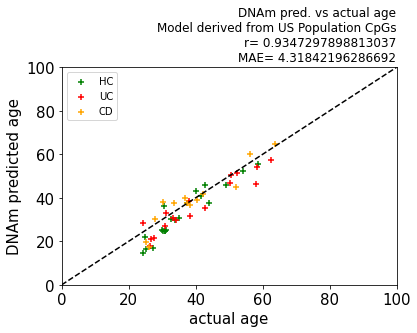

In [242]:
plt.scatter(age_vals[hc_indices], ibs_age_pred_us_pop[hc_indices], label= "HC", marker= "+", color= "green")
plt.scatter(age_vals[uc_indices], ibs_age_pred_us_pop[uc_indices], label= "UC", marker= "+", color= "red")
plt.scatter(age_vals[cd_indices], ibs_age_pred_us_pop[cd_indices], label= "CD", marker= "+", color= "orange")

ibs_file_name = os.path.join(FIGURES_DIR, "ibs_test_us_pop_cpgs")
finalize_scatter_plot(age_vals, ibs_age_pred_us_pop, "Model derived from US Population CpGs", ibs_file_name)

In [243]:
d = {"pred_age": ibs_age_pred_us_pop, "actual_age": age_vals}
d

{'pred_age': array([41.6375683 , 64.64489046, 30.46289953, 37.63532541, 33.12103341,
        38.41065345, 38.14520517, 28.31403888, 39.86565307, 50.57520711,
        60.23831266, 35.1546148 , 36.67810795, 46.84629815, 30.63681186,
        46.33531167, 38.96283751, 54.30873158, 29.82595793, 51.43502901,
        44.80061116, 21.63112623, 17.58832055, 31.85824105, 21.24772002,
        37.57023562, 17.91532175, 19.8383567 , 27.01392142, 57.20545474,
        24.90528983, 36.18815431, 37.44478478, 30.26889917, 37.71608598,
        45.93293147, 55.51379457, 42.9352639 , 24.83842761, 40.64663098,
        24.99183176, 14.77939249, 46.06278641, 30.54555967, 25.20784987,
        29.87814649, 24.91599164, 52.30120108, 16.55542045, 16.76670055,
        22.08030397]),
 'actual_age': array([42.1, 63.7, 27.9, 33.4, 31.3, 38.0, 30.3, 24.3, 36.8, 50.7, 56.3,
        42.7, 38.2, 50.4, 33.1, 58.1, 40.3, 58.4, 34.0, 52.4, 52.0, 27.6,
        26.2, 38.4, 26.7, 37.4, 26.5, 25.1, 30.8, 62.4, 30.8, 30.7, 37.4,

In [244]:
ibs_results = pd.DataFrame(data= d)
ibs_results

,pred_age,actual_age
0,41.637568,42.1
1,64.644890,63.7
2,30.462900,27.9
3,37.635325,33.4
4,33.121033,31.3
5,38.410653,38.0
6,38.145205,30.3
7,28.314039,24.3
8,39.865653,36.8
9,50.575207,50.7


In [245]:
ibs_results.to_csv("./ibs_results_us_pop_model.csv")

## Let's look at an MS dataset

In [246]:
ms_file = open("./MS.pickle", mode= "rb")

In [247]:
ms_df = pickle.load(ms_file)

In [248]:
ms_ages = np.array(ms_df["age"])
for i in range(len(ms_ages)):
    ms_ages[i] = int(ms_ages[i])

disease_status = np.array(ms_df["status"])

In [249]:
healthy_ind = []
ms_ind = []

for s in disease_status:
    if s == "Healthy control":
        healthy_ind.append(True)
        ms_ind.append(False)
    elif s == "MS case":
        healthy_ind.append(False)
        ms_ind.append(True)
    else:
        print("missing one")

In [250]:
ms_df = ms_df[medium_CpG_list]

In [251]:
ms_df = ms_df.iloc[:, filtered_cpgs_ints]
len(ms_df.columns)

139

In [252]:
ms_df.head()

ID_REF,cg02711397,cg16867657,cg01974375,cg08271909,cg11830800,cg27407385,cg18240400,cg19037555,cg17802949,cg07082267,...,cg17372101,cg08323969,cg05318503,cg18343474,cg17983814,cg17621438,cg11431402,cg10052840,cg11571588,cg04604946
GSM2844230,0.171721,0.509865,0.217575,0.784134,0.423834,0.858002,0.321427,0.087279,0.165948,0.400453,...,0.422134,0.235712,0.710674,0.111952,0.945801,0.247120,0.341797,0.470277,0.842428,0.271873
GSM2844231,0.094826,0.443838,0.203211,0.818846,0.483343,0.867031,0.291245,0.064795,0.120119,0.361414,...,0.433362,0.269598,0.732252,0.106614,0.945296,0.323144,0.390676,0.494912,0.823484,0.297128
GSM2844232,0.175491,0.636424,0.198580,0.803140,0.480834,0.891241,0.369772,0.062703,0.156889,0.351467,...,0.459495,0.300231,0.749264,0.129137,0.949751,0.271704,0.394937,0.521664,0.853296,0.281589
GSM2844233,0.186646,0.646220,0.206730,0.853647,0.481886,0.917803,0.353998,0.083596,0.170740,0.342004,...,0.386576,0.300331,0.771385,0.123593,0.951054,0.235489,0.474527,0.533932,0.831568,0.291713
GSM2844234,0.134504,0.580320,0.271577,0.873042,0.553414,0.903591,0.400101,0.106756,0.170685,0.392223,...,0.517560,0.320280,0.735561,0.152774,0.941539,0.333540,0.452848,0.557004,0.857281,0.308166


In [253]:
ms_df = ms_df.fillna(method= "bfill")
ms_df = ms_df.fillna(method= "ffill")

In [254]:
ms_df = medium_us_pop_cpgs_scaler.transform(ms_df)
ms_df

array([[-0.14617589, -2.00582198,  0.23878559, ..., -1.80608735,
        -2.06950065, -1.88216285],
       [-1.24210734, -2.83853168, -0.18684238, ..., -1.11584704,
        -2.89407734, -1.15433262],
       [-0.09245501, -0.4097284 , -0.32407324, ..., -0.36626421,
        -1.59646363, -1.60215682],
       ...,
       [-1.09829469, -2.17164172,  2.04666352, ...,  2.55339272,
         0.45901952,  1.99967848],
       [ 0.5730637 , -0.04432733,  0.12730882, ...,  1.9699077 ,
         0.6827143 ,  0.26641763],
       [-0.00902039, -0.6610806 ,  0.54081101, ...,  1.32449355,
         0.57266786,  0.26953401]])

In [255]:
ms_age_pred_us_pop = medium_model_pop_cpgs.predict(ms_df)

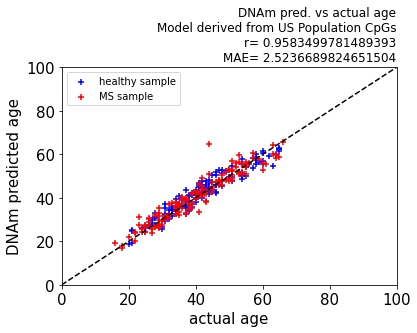

In [256]:
plt.scatter(ms_ages[healthy_ind], ms_age_pred_us_pop[healthy_ind], label= "healthy sample", marker= "+", color= "blue")
plt.scatter(ms_ages[ms_ind], ms_age_pred_us_pop[ms_ind], label= "MS sample", marker= "+", color= "red")

MS_file_name = os.path.join(FIGURES_DIR, "gen_2_medium_model_MS_test")
finalize_scatter_plot(ms_ages, ms_age_pred_us_pop, "Model derived from US Population CpGs", MS_file_name)

In [257]:
d = {"pred_age": ms_age_pred_us_pop, "actual_age": ms_ages}
d

{'pred_age': array([25.88492985, 23.7441272 , 39.31323536, 50.78961297, 38.18604155,
        34.90388142, 51.42916352, 45.93761503, 35.33262025, 43.74036224,
        59.13493024, 26.78509879, 41.08976676, 42.29104645, 53.97605385,
        54.58185222, 41.19513068, 47.04909206, 52.39614861, 55.64813371,
        48.07944196, 50.87645586, 51.57287043, 45.16072212, 48.13169748,
        26.39842989, 43.87802774, 39.0197082 , 24.3507267 , 33.21815106,
        35.79182931, 45.10345342, 31.93683662, 43.78927353, 16.76591239,
        44.11713624, 37.26117067, 42.00665575, 35.09710354, 39.60734908,
        43.05561298, 29.90290774, 37.72137891, 49.78653286, 41.82973476,
        34.73414889, 58.54643467, 27.71426492, 60.82778875, 44.46784869,
        42.59359937, 17.78941522, 28.93891058, 46.45687668, 26.83619363,
        24.15333607, 48.23434843, 41.95047963, 56.48206503, 33.82223339,
        38.12069741, 53.32953937, 38.66777087, 32.50040897, 35.91610848,
        32.62564818, 61.72673022, 55.74

In [258]:
ms_results = pd.DataFrame(data= d)
ms_results

,pred_age,actual_age
0,25.884930,27
1,23.744127,22
2,39.313235,40
3,50.789613,55
4,38.186042,43
...,...,...
274,32.701575,37
275,47.902304,48
276,31.160366,23
277,55.762505,54


In [259]:
ms_results.to_csv("./MS_results_gen_2.csv")

### Let's create a plot showing all disease and healthy samples

In [260]:
all_samples = []
all_predictions = []

healthy_indices = []
diseased_indices = []

# IBS
all_samples.extend(age_vals)
all_predictions.extend(ibs_age_pred_us_pop)
healthy_indices.extend(hc_indices)
ibs_diseased_indices = []
for i in hc_indices:
    if i == True:
        ibs_diseased_indices.append(False)
    else:
        ibs_diseased_indices.append(True)
        
diseased_indices.extend(ibs_diseased_indices)
        
# HIV
all_samples.extend(y_HIV)
all_predictions.extend(age_pred_HIV_medium_pop_cpgs)
hiv_health_indices = []
hiv_dis_indices = []
for _ in range(len(y_HIV)):
    hiv_health_indices.append(False)
    hiv_dis_indices.append(True)
healthy_indices.extend(hiv_health_indices)
diseased_indices.extend(hiv_dis_indices)

# Werner
all_samples.extend(werner_ages)
all_predictions.extend(werner_age_pred_pop_cpgs)
werner_health_indices = []
werner_dis_indices = []
for _ in range(len(werner_ages)):
    werner_health_indices.append(False)
    werner_dis_indices.append(True)
healthy_indices.extend(werner_health_indices)
diseased_indices.extend(werner_dis_indices)

# MS
all_samples.extend(ms_ages)
all_predictions.extend(ms_age_pred_us_pop)
healthy_indices.extend(healthy_ind)        
diseased_indices.extend(ms_ind)

# Down Syndrome
all_samples.extend(y_ds)
all_predictions.extend(medium_pop_cpgs_ds_age_pred)
diseased_indices.extend(ds_c1_ind)
healthy_indices.extend(ds_c0_ind)

# Arthritis
all_samples.extend(y_rheu)
all_predictions.extend(medium_pop_cpgs_arth_age_pred)
diseased_indices.extend(arth_c1_ind)
healthy_indices.extend(arth_c0_ind)

all_samples = np.array(all_samples)
all_predictions = np.array(all_predictions)

In [261]:
len(ibs_age_pred_us_pop)

51

In [262]:
len(all_samples), len(all_predictions)

(1223, 1223)

In [263]:
len(healthy_indices), len(diseased_indices)

(1223, 1223)

In [264]:
num_normal_samples = 0
num_diseased_samples = 0
for is_healthy in healthy_indices:
    if is_healthy:
        num_normal_samples += 1
    else:
        num_diseased_samples += 1

In [265]:
num_normal_samples + num_diseased_samples

1223

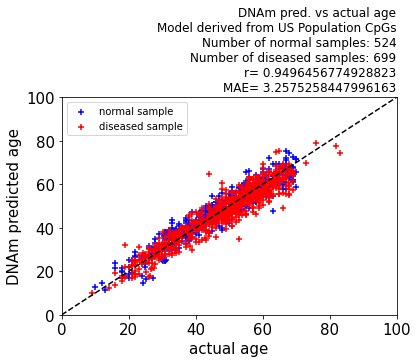

In [266]:
plt.scatter(all_samples[healthy_indices], all_predictions[healthy_indices], label= "normal sample", marker= "+", color= "blue")
plt.scatter(all_samples[diseased_indices], all_predictions[diseased_indices], label= "diseased sample", marker= "+", color= "red")

us_pop_all_datasets_filename = os.path.join(FIGURES_DIR, "us_pop_model_all_datasets")
all_samples_plot_title = f"Model derived from US Population CpGs\nNumber of normal samples: {num_normal_samples}\nNumber of diseased samples: {num_diseased_samples}"
finalize_scatter_plot(all_samples, all_predictions, all_samples_plot_title, us_pop_all_datasets_filename)

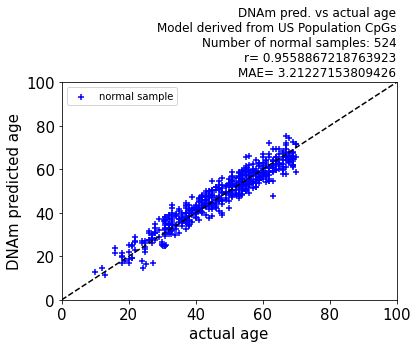

In [267]:
plt.scatter(all_samples[healthy_indices], all_predictions[healthy_indices], label= "normal sample", marker= "+", color= "blue")

us_pop_all_datasets_filename = os.path.join(FIGURES_DIR, "us_pop_model_all_datasets_normal_only")
all_samples_plot_title = f"Model derived from US Population CpGs\nNumber of normal samples: {num_normal_samples}"
finalize_scatter_plot(all_samples[healthy_indices], all_predictions[healthy_indices], all_samples_plot_title, us_pop_all_datasets_filename)

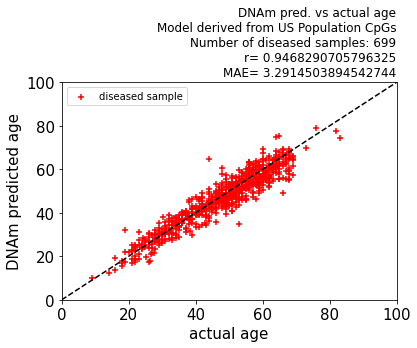

In [268]:
plt.scatter(all_samples[diseased_indices], all_predictions[diseased_indices], label= "diseased sample", marker= "+", color= "red")

us_pop_all_datasets_filename = os.path.join(FIGURES_DIR, "us_pop_model_all_datasets_diseased_only")
all_samples_plot_title = f"Model derived from US Population CpGs\nNumber of diseased samples: {num_diseased_samples}"
finalize_scatter_plot(all_samples[diseased_indices], all_predictions[diseased_indices], all_samples_plot_title, us_pop_all_datasets_filename)